**Chapter 15 – Processing Sequences Using RNNs and CNNs**

_This notebook contains all the sample code and solutions to the exercises in chapter 15._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [67]:
import sys
import os
import numpy as np

sys.path.append("../util")
IMAGES_FOLDER = "rnn"
DATA_FOLDER = "datasets"

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

2025-01-29 22:44:24.987037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738212265.010068 1720240 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738212265.016993 1720240 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 22:44:25.043494: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/rnn` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from ageron_homl3 import save_fig, get_data_root

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

# Basic RNNs

Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

In [24]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=get_data_root(),
    extract=True
)

'/home/richard/Documents/Richard/Projects/rochester/others/handson-ml3/analysis/data/datasets/ridership_extracted'

In [25]:
import pandas as pd
from pathlib import Path

data_path = os.path.join(get_data_root(), DATA_FOLDER,
                         "ridership_extracted", "ridership")
data_file = os.path.join(
    data_path, "CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(data_file, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [26]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):

Saving figure daily_ridership_plot


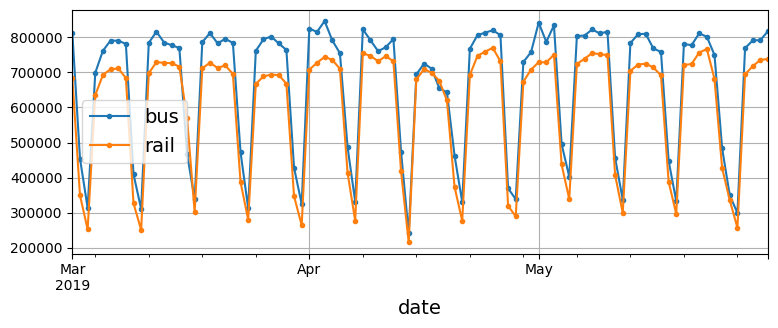

In [27]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
# extra code – saves the figure for the book
save_fig("daily_ridership_plot", images_folder=IMAGES_FOLDER)
plt.show()

Saving figure differencing_plot


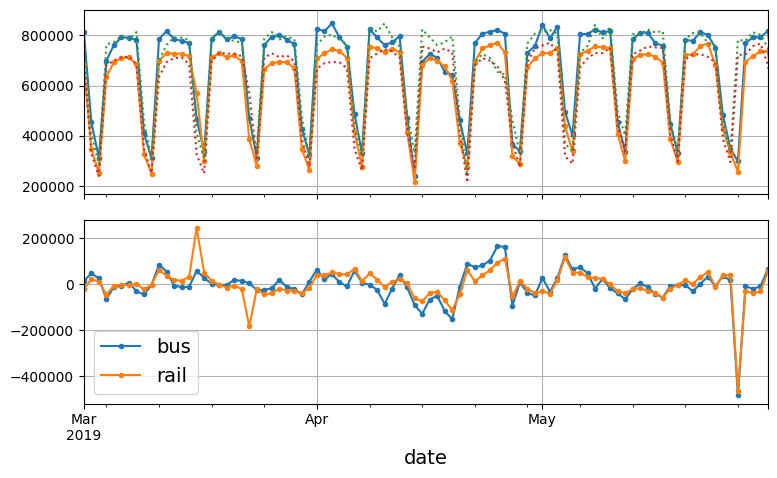

In [28]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
# extra code – saves the figure for the book
save_fig("differencing_plot", images_folder=IMAGES_FOLDER)
plt.show()

In [29]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Mean absolute error (MAE), also called mean absolute deviation (MAD):

In [30]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Mean absolute percentage error (MAPE):

In [31]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

Now let's look at the yearly seasonality and the long-term trends:

Saving figure long_term_ridership_plot


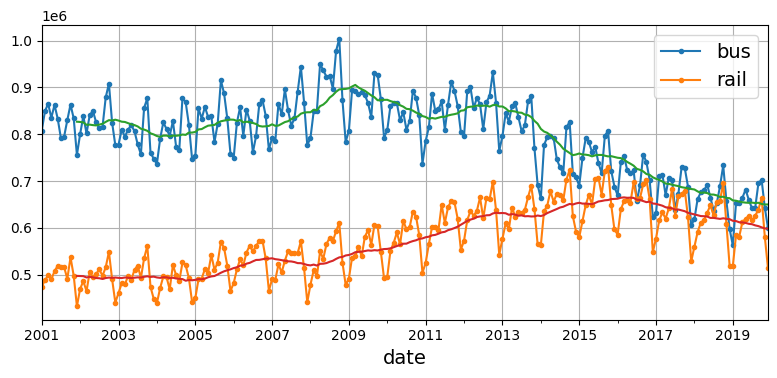

In [68]:
# Ensure the DataFrame only contains numeric columns
df_numeric = df.select_dtypes(include=[np.number])

period = slice("2001", "2019")
df_monthly = df_numeric.resample('ME').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
# extra code – saves the figure for the book
save_fig("long_term_ridership_plot", images_folder=IMAGES_FOLDER)
plt.show()

Saving figure yearly_diff_plot


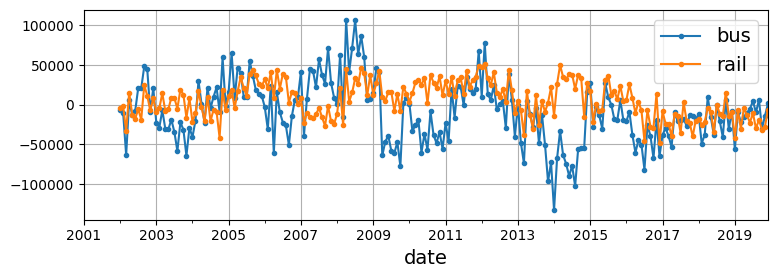

In [69]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
# extra code – saves the figure for the book
save_fig("yearly_diff_plot", images_folder=IMAGES_FOLDER)
plt.show()

If running on Colab or Kaggle, install the statsmodels library:

In [34]:
if "google.colab" in sys.modules:
    %pip install -q -U statsmodels

In [35]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In [39]:
y_pred[0]  # ARIMA forecast

/tmp/ipykernel_1720240/3394422362.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred[0]  # ARIMA forecast


np.float64(427758.62642106105)

In [40]:
df["rail"].loc["2019-06-01"]  # target value

np.int64(379044)

In [41]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

np.int64(426932)

In [42]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

/tmp/ipykernel_1720240/1973171660.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_1720240/1973171660.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_1720240/1973171660.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_1720240/1973171660.py:10: FutureWarning: Series.__getitem__ treating keys

In [43]:
mae

np.float64(32040.720094289627)

/tmp/ipykernel_1720240/1730511358.py:4: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")


Saving figure sarima_forecasts_plot


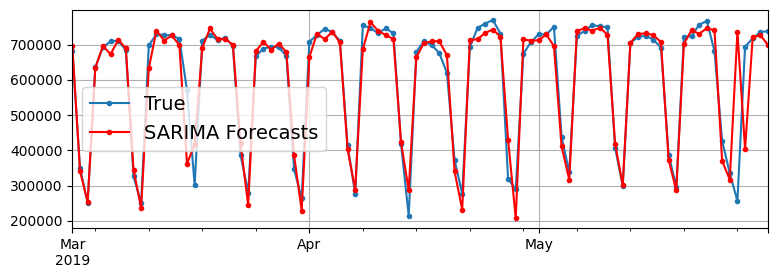

In [44]:
# extra code – displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
save_fig("sarima_forecasts_plot", images_folder=IMAGES_FOLDER)
plt.show()

Saving figure acf_pacf_plot


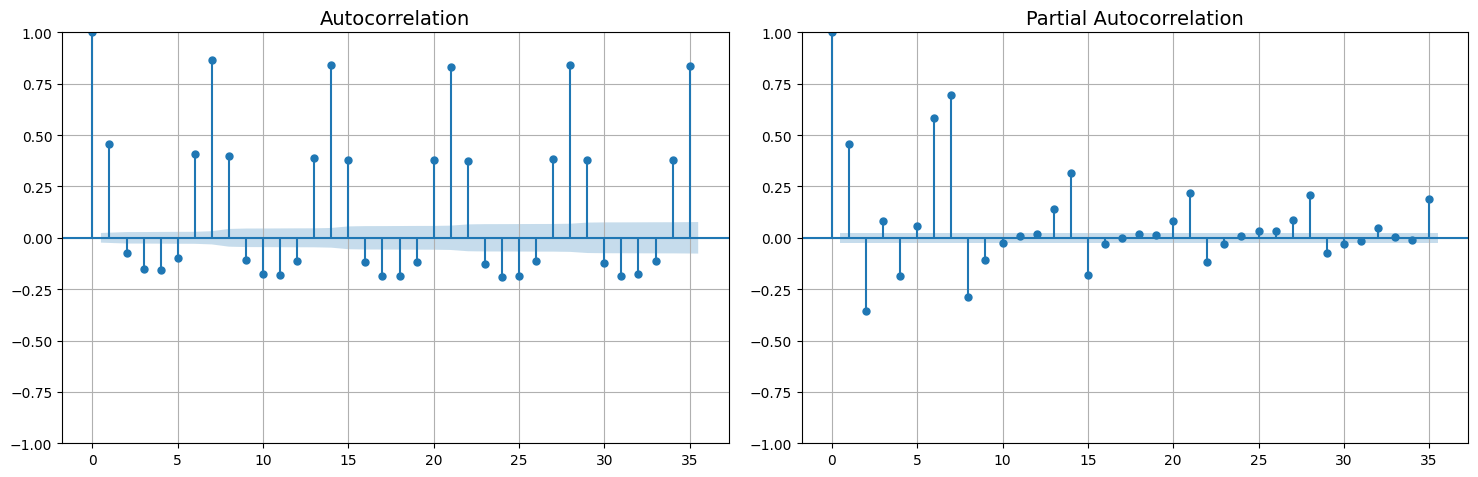

In [49]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
save_fig("acf_pacf_plot", images_folder=IMAGES_FOLDER)
plt.show()

In [50]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

2025-01-29 22:51:35.270856: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [51]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2025-01-29 22:51:39.176977: W tensorflow/core/framework/dataset.cc:993] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2025-01-29 22:51:39.183132: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-29 22:51:39.201565: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-29 22:51:39.231778: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [52]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [53]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [54]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [55]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [56]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [44]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

/home/richard/Documents/Richard/Projects/rochester/others/handson-ml3/homl3-tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500


I0000 00:00:1738209669.136119 1648369 service.cc:148] XLA service 0x7f3a48026420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738209669.136148 1648369 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1738209669.136156 1648369 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1738209669.136158 1648369 service.cc:156]   StreamExecutor device (2): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1738209669.136161 1648369 service.cc:156]   StreamExecutor device (3): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1738209669.136164 1648369 service.cc:156]   StreamExecutor device (4): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1738209669.136167 1648369 service.cc:156]   StreamExecutor device (5): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1738209669.1361

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5007 - mae: 0.9203   

I0000 00:00:1738209669.417526 1648369 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.4216 - mae: 0.8195 - val_loss: 0.0269 - val_mae: 0.1950
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0258 - mae: 0.1844 - val_loss: 0.0084 - val_mae: 0.0929
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - mae: 0.0954 - val_loss: 0.0071 - val_mae: 0.0863
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072 - mae: 0.0879 - val_loss: 0.0066 - val_mae: 0.0830
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0073 - mae: 0.0881 - val_loss: 0.0062 - val_mae: 0.0809
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - mae: 0.0791 - val_loss: 0.0057 - val_mae: 0.0753
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - mae: 0.0771 - val_loss: 0.0061 - val_mae: 0.0784
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mae: 0.0747 - val_loss: 0.0063 - val_mae: 0.0803
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - mae: 0.

In [33]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 [==============================] - 0s 2ms/step - loss: 0.0022 - mae: 0.0379


37866.38006567955

## Using a Simple RNN

In [57]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

/home/richard/Documents/Richard/Projects/rochester/others/handson-ml3/homl3-tf/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [58]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [59]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500


I0000 00:00:1738212729.532013 1720729 service.cc:148] XLA service 0x564ba0a73860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738212729.532044 1720729 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1738212729.532052 1720729 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1738212729.532054 1720729 service.cc:156]   StreamExecutor device (2): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1738212729.532057 1720729 service.cc:156]   StreamExecutor device (3): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1738212729.532060 1720729 service.cc:156]   StreamExecutor device (4): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1738212729.532062 1720729 service.cc:156]   StreamExecutor device (5): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1738212729.5320

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1252 - mae: 0.3574

I0000 00:00:1738212729.999065 1720729 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1126 - mae: 0.3398 - val_loss: 0.0426 - val_mae: 0.2347
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0276 - mae: 0.1755 - val_loss: 0.0151 - val_mae: 0.1480
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0159 - mae: 0.1581 - val_loss: 0.0154 - val_mae: 0.1397
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0155 - mae: 0.1582 - val_loss: 0.0155 - val_mae: 0.1363
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0160 - mae: 0.1577 - val_loss: 0.0153 - val_mae: 0.1381
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0157 - mae: 0.1573 - val_loss: 0.0151 - val_mae: 0.1399
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0156 - mae: 0.1568 - val_loss: 0.0152 - val_mae: 0.1383
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0145 - mae: 0.1519 - val_loss: 0.0150 - val_mae: 0.1407
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0153 - mae: 0.

102736.41347885132

In [70]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

/home/richard/Documents/Richard/Projects/rochester/others/handson-ml3/homl3-tf/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 1s 13ms/step - loss: 0.0489 - mae: 0.2061 - val_loss: 0.0060 - val_mae: 0.0854
Epoch 2/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0060 - mae: 0.0813 - val_loss: 0.0052 - val_mae: 0.0825
Epoch 3/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0042 - mae: 0.0647 - val_loss: 0.0041 - val_mae: 0.0656
Epoch 4/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0041 - mae: 0.0636 - val_loss: 0.0042 - val_mae: 0.0714
Epoch 5/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0039 - mae: 0.0595 - val_loss: 0.0023 - val_mae: 0.0387
Epoch 6/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0033 - mae: 0.0542 - val_loss: 0.0026 - val_mae: 0.0423
Epoch 7/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0032 - mae: 0.0502 - val_loss: 0.0021 - val_mae: 0.0354
Epoch 8/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0030 -

29014.97296988964

## Deep RNNs

In [60]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [61]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500


33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.0231 - mae: 0.1620 - val_loss: 0.0093 - val_mae: 0.1094
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0083 - mae: 0.0957 - val_loss: 0.0033 - val_mae: 0.0608
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0071 - mae: 0.0901 - val_loss: 0.0025 - val_mae: 0.0496
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0045 - mae: 0.0645 - val_loss: 0.0021 - val_mae: 0.0403
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0043 - mae: 0.0608 - val_loss: 0.0020 - val_mae: 0.0383
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0039 - mae: 0.0555 - val_loss: 0.0021 - val_mae: 0.0388
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0041 - mae: 0.0572 - val_loss: 0.0019 - val_mae: 0.0356
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0042 - mae: 0.0581 - val_loss: 0.0024 - val_mae: 0.0448
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0037 -

30083.1850618124

## Multivariate time series

In [71]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [97]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [73]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

# Convert data to float32
mulvar_train_np = mulvar_train.to_numpy().astype(np.float32)
mulvar_valid_np = mulvar_valid.to_numpy().astype(np.float32)

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train_np,  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid_np,
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [74]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

/home/richard/Documents/Richard/Projects/rochester/others/handson-ml3/homl3-tf/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0386 - mae: 0.1872 - val_loss: 0.0011 - val_mae: 0.0346
Epoch 2/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0029 - mae: 0.0585 - val_loss: 0.0040 - val_mae: 0.0790
Epoch 3/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0018 - mae: 0.0435 - val_loss: 7.7056e-04 - val_mae: 0.0273
Epoch 4/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0017 - mae: 0.0407 - val_loss: 0.0010 - val_mae: 0.0362
Epoch 5/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0015 - mae: 0.0386 - val_loss: 8.1681e-04 - val_mae: 0.0306
Epoch 6/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0014 - mae: 0.0372 - val_loss: 0.0011 - val_mae: 0.0380
Epoch 7/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0014 - mae: 0.0366 - val_loss: 7.9942e-04 - val_mae: 0.0289
Epoch 8/500
33/33 [==============================] - 0s 10ms/step

22062.301635742188

In [77]:
# extra code – build and train a multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy().astype(np.float32),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy().astype(np.float32),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500


/home/richard/Documents/Richard/Projects/rochester/others/handson-ml3/homl3-tf/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0443 - mae: 0.2198 - val_loss: 0.0034 - val_mae: 0.0653
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040 - mae: 0.0657 - val_loss: 0.0021 - val_mae: 0.0465
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - mae: 0.0527 - val_loss: 0.0022 - val_mae: 0.0552
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0023 - mae: 0.0492 - val_loss: 0.0012 - val_mae: 0.0367
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021 - mae: 0.0473 - val_loss: 0.0015 - val_mae: 0.0434
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - mae: 0.0445 - val_loss: 0.0014 - val_mae: 0.0415
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - mae: 0.0450 - val_loss: 0.0012 - val_mae: 0.0372
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - mae: 0.0425 - val_loss: 0.0014 - val_mae: 0.0417
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 -

26629.412546753883

In [78]:
# extra code – evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

np.float64(43441.63157894738)

In [81]:
# extra code – evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


AttributeError: module 'keras._tf_keras.keras.metrics' has no attribute 'mean_absolute_error'

## Forecasting Several Steps Ahead

In [82]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


Saving figure forecast_ahead_plot


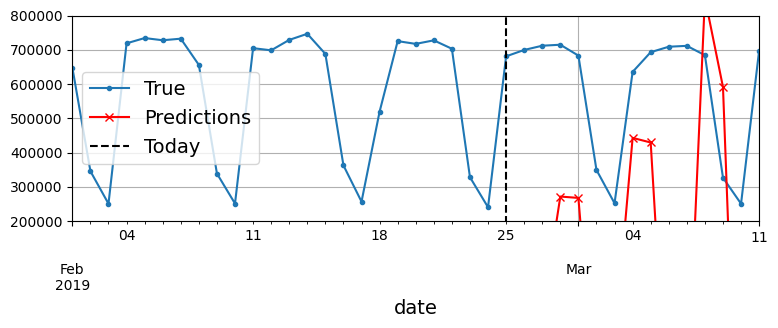

In [83]:
# extra code – generates and saves Figure 15–11

# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
save_fig("forecast_ahead_plot", images_folder=IMAGES_FOLDER)
plt.show()

Now let's create an RNN that predicts all 14 next values at once:

In [85]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy().astype(np.float32),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy().astype(np.float32),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [86]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/home/richard/Documents/Richard/Projects/rochester/others/handson-ml3/homl3-tf/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [87]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.1721 - mae: 0.4593 - val_loss: 0.0292 - val_mae: 0.1954
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0248 - mae: 0.1833 - val_loss: 0.0178 - val_mae: 0.1464
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0177 - mae: 0.1552 - val_loss: 0.0147 - val_mae: 0.1373
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0157 - mae: 0.1481 - val_loss: 0.0134 - val_mae: 0.1291
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0146 - mae: 0.1419 - val_loss: 0.0126 - val_mae: 0.1226
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0136 - mae: 0.1365 - val_loss: 0.0118 - val_mae: 0.1176
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0128 - mae: 0.1309 - val_loss: 0.0109 - val_mae: 0.1150
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0118 - mae: 0.1264 - val_loss: 0.0104 - val_mae: 0.1114
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0114 -

36301.65755748749

In [92]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X.astype(float))  # shape [1, 14]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Now let's create an RNN that predicts the next 14 steps at each time step. That is, instead of just forecasting time steps 56 to 69 based on time steps 0 to 55, it will forecast time steps 1 to 14 at time step 0, then time steps 2 to 15 at time step 1, and so on, and finally it will forecast time steps 56 to 69 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

To prepare the datasets, we can use `to_windows()` twice, to get sequences of consecutive windows, like this:

In [93]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

Then we can split these elements into the desired inputs and targets:

In [94]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

Let's wrap this idea into a utility function. It will also take care of shuffling (optional) and batching:

In [95]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [103]:
seq2seq_train = to_seq2seq_dataset(
    mulvar_train.to_numpy().astype(float), shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid.to_numpy().astype(float))

In [104]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/home/richard/Documents/Richard/Projects/rochester/others/handson-ml3/homl3-tf/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [105]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
     33/Unknown 3s 34ms/step - loss: 0.1261 - mae: 0.3778

2025-01-29 23:53:41.259477: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:41.259569: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
/home/richard/Documents/Richard/Projects/rochester/others/handson-ml3/homl3-tf/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.1242 - mae: 0.3741 - val_loss: 0.0138 - val_mae: 0.1220
Epoch 2/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0117 - mae: 0.1130  

2025-01-29 23:53:42.247565: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-29 23:53:42.247632: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:42.247674: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0102 - mae: 0.1042 - val_loss: 0.0068 - val_mae: 0.0799
Epoch 3/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0059 - mae: 0.0777

2025-01-29 23:53:42.660686: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:42.660777: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:42.738162: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:42.738211: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0063 - mae: 0.0782 - val_loss: 0.0056 - val_mae: 0.0703
Epoch 4/500


2025-01-29 23:53:43.163287: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:43.163355: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:43.244076: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:43.244132: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0054 - mae: 0.0714 - val_loss: 0.0053 - val_mae: 0.0684
Epoch 5/500


2025-01-29 23:53:43.695186: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:43.695257: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:43.778470: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:43.778525: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0050 - mae: 0.0675 - val_loss: 0.0050 - val_mae: 0.0652
Epoch 6/500


2025-01-29 23:53:44.216310: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:44.216379: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:44.296666: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-29 23:53:44.296706: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:44.296729: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0047 - mae: 0.0651 - val_loss: 0.0047 - val_mae: 0.0620
Epoch 7/500


2025-01-29 23:53:44.745380: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:44.745455: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:44.826550: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:44.826597: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0045 - mae: 0.0642 - val_loss: 0.0048 - val_mae: 0.0637
Epoch 8/500


2025-01-29 23:53:45.266921: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:45.266994: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:45.347220: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:45.347277: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0044 - mae: 0.0626 - val_loss: 0.0046 - val_mae: 0.0613
Epoch 9/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0035 - mae: 0.0576

2025-01-29 23:53:45.749907: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:45.749971: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:45.826464: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:45.826515: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0043 - mae: 0.0616 - val_loss: 0.0044 - val_mae: 0.0592
Epoch 10/500


2025-01-29 23:53:46.260026: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:46.260082: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:46.343624: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:46.343676: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0041 - mae: 0.0607 - val_loss: 0.0043 - val_mae: 0.0581
Epoch 11/500


2025-01-29 23:53:46.795638: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:46.795719: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:46.875706: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:46.875760: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0041 - mae: 0.0606 - val_loss: 0.0044 - val_mae: 0.0597
Epoch 12/500


2025-01-29 23:53:47.314687: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:47.314746: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:47.395838: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:47.395896: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0041 - mae: 0.0604 - val_loss: 0.0043 - val_mae: 0.0584
Epoch 13/500


2025-01-29 23:53:47.830432: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:47.830498: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:47.913112: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:47.913174: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0040 - mae: 0.0594 - val_loss: 0.0043 - val_mae: 0.0581
Epoch 14/500


2025-01-29 23:53:48.344804: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:48.344873: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:48.424521: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-29 23:53:48.424561: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:48.424583: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040 - mae: 0.0583 - val_loss: 0.0043 - val_mae: 0.0584
Epoch 15/500


2025-01-29 23:53:48.840851: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:48.840920: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:48.925138: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:48.925194: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0039 - mae: 0.0576 - val_loss: 0.0044 - val_mae: 0.0593
Epoch 16/500


2025-01-29 23:53:49.357273: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:49.357345: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:49.438186: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:49.438229: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0038 - mae: 0.0575 - val_loss: 0.0041 - val_mae: 0.0554
Epoch 17/500


2025-01-29 23:53:49.867029: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:49.867095: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:49.949400: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:49.949446: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0038 - mae: 0.0574 - val_loss: 0.0041 - val_mae: 0.0554
Epoch 18/500


2025-01-29 23:53:50.382569: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:50.382669: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:50.466526: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:50.466572: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0038 - mae: 0.0570 - val_loss: 0.0041 - val_mae: 0.0557
Epoch 19/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0028 - mae: 0.0511

2025-01-29 23:53:50.915296: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:50.915359: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:50.995586: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:50.995636: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0038 - mae: 0.0563 - val_loss: 0.0042 - val_mae: 0.0571
Epoch 20/500


2025-01-29 23:53:51.425238: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:51.425294: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:51.510694: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:51.510737: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037 - mae: 0.0562 - val_loss: 0.0042 - val_mae: 0.0569
Epoch 21/500


2025-01-29 23:53:51.932057: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:51.932130: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:52.010417: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:52.010463: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0037 - mae: 0.0555 - val_loss: 0.0041 - val_mae: 0.0550
Epoch 22/500


2025-01-29 23:53:52.463001: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:52.463074: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:52.540267: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0037 - mae: 0.0557 - val_loss: 0.0040 - val_mae: 0.0544
Epoch 23/500


2025-01-29 23:53:52.981524: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:52.981598: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:53.065884: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:53.065946: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0037 - mae: 0.0561 - val_loss: 0.0040 - val_mae: 0.0539
Epoch 24/500


2025-01-29 23:53:53.492890: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:53.492955: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:53.572017: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:53.572060: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0038 - mae: 0.0574 - val_loss: 0.0039 - val_mae: 0.0532
Epoch 25/500


2025-01-29 23:53:54.008548: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:54.008621: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:54.093803: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:54.093845: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0037 - mae: 0.0560 - val_loss: 0.0039 - val_mae: 0.0533
Epoch 26/500


2025-01-29 23:53:54.535135: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:54.535218: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:54.617713: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:54.617771: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0037 - mae: 0.0557 - val_loss: 0.0040 - val_mae: 0.0536
Epoch 27/500


2025-01-29 23:53:55.060865: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:55.060937: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:55.144007: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:55.144051: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0036 - mae: 0.0542 - val_loss: 0.0039 - val_mae: 0.0528
Epoch 28/500


2025-01-29 23:53:55.568879: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:55.568947: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:55.649727: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:55.649767: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0035 - mae: 0.0540 - val_loss: 0.0039 - val_mae: 0.0529
Epoch 29/500


2025-01-29 23:53:56.105411: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:56.105479: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:56.191582: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:56.191650: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0036 - mae: 0.0547 - val_loss: 0.0038 - val_mae: 0.0520
Epoch 30/500


2025-01-29 23:53:56.641065: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:56.641137: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:56.725479: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-29 23:53:56.725529: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:56.725559: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0036 - mae: 0.0553 - val_loss: 0.0039 - val_mae: 0.0520
Epoch 31/500


2025-01-29 23:53:57.155106: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:57.155178: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:57.233149: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:57.233191: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035 - mae: 0.0534 - val_loss: 0.0039 - val_mae: 0.0519
Epoch 32/500


2025-01-29 23:53:57.660893: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:57.660954: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:57.738036: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:57.738077: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035 - mae: 0.0538 - val_loss: 0.0039 - val_mae: 0.0526
Epoch 33/500


2025-01-29 23:53:58.153572: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:58.153629: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:58.233511: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:58.233565: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0035 - mae: 0.0530 - val_loss: 0.0039 - val_mae: 0.0519
Epoch 34/500


2025-01-29 23:53:58.679342: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:58.679408: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:58.761951: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:58.762004: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0034 - mae: 0.0526 - val_loss: 0.0039 - val_mae: 0.0519
Epoch 35/500


2025-01-29 23:53:59.189355: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:59.189421: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:59.272065: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:59.272112: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0034 - mae: 0.0522 - val_loss: 0.0039 - val_mae: 0.0522
Epoch 36/500


2025-01-29 23:53:59.711256: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:59.711322: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:53:59.791670: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:53:59.791719: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0035 - mae: 0.0531 - val_loss: 0.0039 - val_mae: 0.0521
Epoch 37/500


2025-01-29 23:54:00.230064: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:00.230136: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:00.313403: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:00.313450: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034 - mae: 0.0517 - val_loss: 0.0038 - val_mae: 0.0515
Epoch 38/500


2025-01-29 23:54:00.768873: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:00.768965: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:00.849118: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:00.849171: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0035 - mae: 0.0535 - val_loss: 0.0039 - val_mae: 0.0517
Epoch 39/500


2025-01-29 23:54:01.277818: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:01.277889: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:01.358127: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:01.358186: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034 - mae: 0.0524 - val_loss: 0.0038 - val_mae: 0.0514
Epoch 40/500


2025-01-29 23:54:01.810812: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:01.810879: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:01.890001: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:01.890058: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0034 - mae: 0.0519 - val_loss: 0.0039 - val_mae: 0.0519
Epoch 41/500


2025-01-29 23:54:02.323848: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:02.323902: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:02.405757: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:02.405798: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034 - mae: 0.0524 - val_loss: 0.0038 - val_mae: 0.0510
Epoch 42/500


2025-01-29 23:54:02.852558: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:02.852628: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:02.936790: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:02.936843: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034 - mae: 0.0527 - val_loss: 0.0038 - val_mae: 0.0511
Epoch 43/500


2025-01-29 23:54:03.385699: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:03.385763: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:03.465935: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:03.465983: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034 - mae: 0.0528 - val_loss: 0.0038 - val_mae: 0.0509
Epoch 44/500


2025-01-29 23:54:03.908395: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:03.908451: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:03.991243: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:03.991301: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034 - mae: 0.0519 - val_loss: 0.0038 - val_mae: 0.0513
Epoch 45/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0024 - mae: 0.0470

2025-01-29 23:54:04.412460: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:04.412524: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:04.490092: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:04.490137: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0033 - mae: 0.0510 - val_loss: 0.0038 - val_mae: 0.0510
Epoch 46/500


2025-01-29 23:54:04.940843: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:04.940923: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:05.023465: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:05.023511: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - mae: 0.0514 - val_loss: 0.0038 - val_mae: 0.0510
Epoch 47/500


2025-01-29 23:54:05.441440: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:05.441490: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:05.519339: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:05.519392: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0035 - mae: 0.0530 - val_loss: 0.0038 - val_mae: 0.0505
Epoch 48/500


2025-01-29 23:54:05.975206: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:05.975263: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:06.054012: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:06.054060: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034 - mae: 0.0523 - val_loss: 0.0038 - val_mae: 0.0505
Epoch 49/500


2025-01-29 23:54:06.510892: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:06.510978: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:06.594766: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:06.594819: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034 - mae: 0.0517 - val_loss: 0.0038 - val_mae: 0.0507
Epoch 50/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0028 - mae: 0.0519

2025-01-29 23:54:07.014761: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:07.014825: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:07.094992: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:07.095050: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0034 - mae: 0.0518 - val_loss: 0.0038 - val_mae: 0.0506
Epoch 51/500


2025-01-29 23:54:07.534699: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:07.534762: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:07.611445: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:07.611490: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0033 - mae: 0.0513 - val_loss: 0.0038 - val_mae: 0.0508
Epoch 52/500


2025-01-29 23:54:08.065988: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:08.066049: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:08.146116: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:08.146174: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0033 - mae: 0.0508 - val_loss: 0.0038 - val_mae: 0.0514
Epoch 53/500


2025-01-29 23:54:08.598828: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:08.598898: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:08.680455: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:08.680503: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - mae: 0.0500 - val_loss: 0.0038 - val_mae: 0.0506
Epoch 54/500


2025-01-29 23:54:09.098442: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:09.098506: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:09.179167: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:09.179223: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - mae: 0.0498 - val_loss: 0.0038 - val_mae: 0.0508
Epoch 55/500


2025-01-29 23:54:09.633100: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:09.633159: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:09.713498: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:09.713558: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032 - mae: 0.0500 - val_loss: 0.0038 - val_mae: 0.0516
Epoch 56/500


2025-01-29 23:54:10.144466: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:10.144530: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:10.226023: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:10.226071: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0033 - mae: 0.0514 - val_loss: 0.0038 - val_mae: 0.0513
Epoch 57/500


2025-01-29 23:54:10.679592: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:10.679662: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:10.767713: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:10.767773: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032 - mae: 0.0499 - val_loss: 0.0038 - val_mae: 0.0503
Epoch 58/500


2025-01-29 23:54:11.196510: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:11.196561: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:11.280752: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:11.280802: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032 - mae: 0.0501 - val_loss: 0.0038 - val_mae: 0.0504
Epoch 59/500


2025-01-29 23:54:11.715164: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:11.715234: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:11.797908: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:11.797948: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0033 - mae: 0.0508 - val_loss: 0.0037 - val_mae: 0.0499
Epoch 60/500


2025-01-29 23:54:12.238464: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:12.238528: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:12.326894: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0033 - mae: 0.0505 - val_loss: 0.0038 - val_mae: 0.0510
Epoch 61/500


2025-01-29 23:54:12.762346: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:12.762409: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:12.839354: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:12.839396: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032 - mae: 0.0493 - val_loss: 0.0038 - val_mae: 0.0504
Epoch 62/500


2025-01-29 23:54:13.280724: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:13.280777: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:13.363594: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-29 23:54:13.363639: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:13.363663: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - mae: 0.0505 - val_loss: 0.0038 - val_mae: 0.0501
Epoch 63/500


2025-01-29 23:54:13.779380: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:13.779439: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:13.860051: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:13.860094: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032 - mae: 0.0499 - val_loss: 0.0038 - val_mae: 0.0502
Epoch 64/500


2025-01-29 23:54:14.287400: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:14.287466: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:14.368071: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:14.368117: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - mae: 0.0499 - val_loss: 0.0038 - val_mae: 0.0506
Epoch 65/500


2025-01-29 23:54:14.823959: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:14.824014: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:14.905130: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:14.905179: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032 - mae: 0.0494 - val_loss: 0.0039 - val_mae: 0.0522
Epoch 66/500


2025-01-29 23:54:15.341095: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:15.341160: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:15.420570: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:15.420615: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032 - mae: 0.0492 - val_loss: 0.0040 - val_mae: 0.0549
Epoch 67/500


2025-01-29 23:54:15.852769: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:15.852837: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:15.935166: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:15.935224: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - mae: 0.0496 - val_loss: 0.0038 - val_mae: 0.0502
Epoch 68/500


2025-01-29 23:54:16.351130: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:16.351183: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:16.429656: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:16.429708: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0033 - mae: 0.0503 - val_loss: 0.0038 - val_mae: 0.0505
Epoch 69/500


2025-01-29 23:54:16.854572: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:16.854657: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:16.937305: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:16.937357: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032 - mae: 0.0498 - val_loss: 0.0037 - val_mae: 0.0497
Epoch 70/500


2025-01-29 23:54:17.366890: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:17.366946: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - mae: 0.0496 - val_loss: 0.0037 - val_mae: 0.0493
Epoch 71/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0026 - mae: 0.0480

2025-01-29 23:54:17.862646: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:17.862699: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:17.937753: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:17.937806: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - mae: 0.0499 - val_loss: 0.0037 - val_mae: 0.0494
Epoch 72/500


2025-01-29 23:54:18.363968: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:18.364033: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:18.444414: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:18.444471: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - mae: 0.0500 - val_loss: 0.0037 - val_mae: 0.0495
Epoch 73/500


2025-01-29 23:54:18.889901: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:18.889958: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:18.974865: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:18.974924: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0033 - mae: 0.0506 - val_loss: 0.0037 - val_mae: 0.0493
Epoch 74/500


2025-01-29 23:54:19.419716: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:19.419789: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:19.504215: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:19.504267: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - mae: 0.0498 - val_loss: 0.0037 - val_mae: 0.0496
Epoch 75/500


2025-01-29 23:54:19.954094: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:19.954159: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:20.036267: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:20.036323: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032 - mae: 0.0504 - val_loss: 0.0037 - val_mae: 0.0493
Epoch 76/500


2025-01-29 23:54:20.467389: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:20.467470: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:20.548680: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:20.548734: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0033 - mae: 0.0508 - val_loss: 0.0037 - val_mae: 0.0497
Epoch 77/500


2025-01-29 23:54:20.986519: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:20.986587: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:21.068931: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:21.068995: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - mae: 0.0512 - val_loss: 0.0037 - val_mae: 0.0510
Epoch 78/500


2025-01-29 23:54:21.487646: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:21.487712: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:21.571367: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:21.571433: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - mae: 0.0521 - val_loss: 0.0037 - val_mae: 0.0493
Epoch 79/500


2025-01-29 23:54:21.993766: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:21.993835: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:22.076210: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:22.076266: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - mae: 0.0497 - val_loss: 0.0037 - val_mae: 0.0492
Epoch 80/500


2025-01-29 23:54:22.496266: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:22.496328: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:22.578997: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:22.579044: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - mae: 0.0487 - val_loss: 0.0037 - val_mae: 0.0497
Epoch 81/500


2025-01-29 23:54:23.022463: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:23.022528: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:23.099466: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:23.099525: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032 - mae: 0.0491 - val_loss: 0.0037 - val_mae: 0.0496
Epoch 82/500


2025-01-29 23:54:23.534366: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:23.534442: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:23.617999: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:23.618059: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - mae: 0.0494 - val_loss: 0.0037 - val_mae: 0.0498
Epoch 83/500


2025-01-29 23:54:24.070358: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:24.070417: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:24.152209: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:24.152270: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0033 - mae: 0.0505 - val_loss: 0.0037 - val_mae: 0.0492
Epoch 84/500


2025-01-29 23:54:24.600625: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:24.600704: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:24.688550: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:24.688623: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - mae: 0.0490 - val_loss: 0.0037 - val_mae: 0.0491
Epoch 85/500


2025-01-29 23:54:25.135091: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:25.135150: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:25.216273: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:25.216329: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - mae: 0.0491 - val_loss: 0.0037 - val_mae: 0.0494
Epoch 86/500


2025-01-29 23:54:25.676389: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:25.676476: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:25.757574: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:25.757647: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - mae: 0.0496 - val_loss: 0.0037 - val_mae: 0.0494
Epoch 87/500


2025-01-29 23:54:26.204431: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:26.204483: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:26.289299: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:26.289353: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - mae: 0.0484 - val_loss: 0.0037 - val_mae: 0.0496
Epoch 88/500


2025-01-29 23:54:26.735444: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:26.735511: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:26.818382: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:26.818455: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - mae: 0.0490 - val_loss: 0.0037 - val_mae: 0.0493
Epoch 89/500


2025-01-29 23:54:27.276242: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:27.276305: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:27.355289: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:27.355342: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - mae: 0.0484 - val_loss: 0.0037 - val_mae: 0.0494
Epoch 90/500


2025-01-29 23:54:27.794036: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:27.794096: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:27.879136: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:27.879195: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - mae: 0.0487 - val_loss: 0.0037 - val_mae: 0.0494
Epoch 91/500


2025-01-29 23:54:28.312249: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:28.312322: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:28.391693: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:28.391761: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - mae: 0.0482 - val_loss: 0.0037 - val_mae: 0.0494
Epoch 92/500


2025-01-29 23:54:28.815369: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:28.815448: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:28.901917: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:28.901961: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - mae: 0.0486 - val_loss: 0.0038 - val_mae: 0.0500
Epoch 93/500


2025-01-29 23:54:29.360442: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:29.360495: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:29.441551: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:29.441592: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - mae: 0.0485 - val_loss: 0.0037 - val_mae: 0.0492
Epoch 94/500


2025-01-29 23:54:29.871214: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:29.871281: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:29.954986: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:29.955045: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032 - mae: 0.0492 - val_loss: 0.0037 - val_mae: 0.0490
Epoch 95/500


2025-01-29 23:54:30.390897: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:30.390950: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:30.473309: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:30.473363: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034 - mae: 0.0516 - val_loss: 0.0036 - val_mae: 0.0488
Epoch 96/500


2025-01-29 23:54:30.924483: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:31.007619: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:31.007665: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - mae: 0.0492 - val_loss: 0.0037 - val_mae: 0.0489
Epoch 97/500


2025-01-29 23:54:31.427233: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:31.427293: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:31.507997: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:31.508039: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - mae: 0.0494 - val_loss: 0.0037 - val_mae: 0.0507
Epoch 98/500


2025-01-29 23:54:31.947756: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:31.947821: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:32.028934: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:32.028971: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0033 - mae: 0.0507 - val_loss: 0.0037 - val_mae: 0.0492
Epoch 99/500


2025-01-29 23:54:32.461970: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:32.462037: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:32.542211: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:32.542254: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032 - mae: 0.0489 - val_loss: 0.0037 - val_mae: 0.0493
Epoch 100/500


2025-01-29 23:54:32.982828: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:32.982896: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - mae: 0.0485 - val_loss: 0.0037 - val_mae: 0.0493
Epoch 101/500


2025-01-29 23:54:33.487337: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:33.487397: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:33.565116: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:33.565170: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0488 - val_loss: 0.0037 - val_mae: 0.0491
Epoch 102/500


2025-01-29 23:54:33.959685: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:33.959743: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:34.043182: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:34.043226: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - mae: 0.0486 - val_loss: 0.0037 - val_mae: 0.0492
Epoch 103/500


2025-01-29 23:54:34.464386: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:34.464440: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:34.544804: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:34.544846: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - mae: 0.0487 - val_loss: 0.0037 - val_mae: 0.0493
Epoch 104/500


2025-01-29 23:54:34.980218: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:34.980280: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:35.060954: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:35.061006: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - mae: 0.0486 - val_loss: 0.0037 - val_mae: 0.0492
Epoch 105/500


2025-01-29 23:54:35.477382: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:35.477448: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:35.561502: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:35.561548: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - mae: 0.0487 - val_loss: 0.0037 - val_mae: 0.0488
Epoch 106/500


2025-01-29 23:54:35.993544: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:35.993603: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:36.076382: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:36.076436: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - mae: 0.0491 - val_loss: 0.0037 - val_mae: 0.0487
Epoch 107/500


2025-01-29 23:54:36.505550: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:36.505612: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:36.586482: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:36.586535: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - mae: 0.0484 - val_loss: 0.0037 - val_mae: 0.0490
Epoch 108/500


2025-01-29 23:54:37.033776: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:37.033836: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:37.117311: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:37.117366: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - mae: 0.0477 - val_loss: 0.0037 - val_mae: 0.0492
Epoch 109/500


2025-01-29 23:54:37.542106: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:37.542173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:37.622963: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:37.623011: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0477 - val_loss: 0.0037 - val_mae: 0.0491
Epoch 110/500


2025-01-29 23:54:38.072201: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:38.072255: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:38.150698: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:38.150771: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - mae: 0.0481 - val_loss: 0.0037 - val_mae: 0.0492
Epoch 111/500


2025-01-29 23:54:38.586404: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:38.586464: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:38.668432: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:38.668490: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - mae: 0.0487 - val_loss: 0.0038 - val_mae: 0.0500
Epoch 112/500


2025-01-29 23:54:39.105110: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:39.105179: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:39.188888: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:39.188933: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032 - mae: 0.0490 - val_loss: 0.0037 - val_mae: 0.0488
Epoch 113/500


2025-01-29 23:54:39.628636: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:39.628705: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:39.711105: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:39.711148: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - mae: 0.0491 - val_loss: 0.0036 - val_mae: 0.0487
Epoch 114/500


2025-01-29 23:54:40.144006: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:40.144069: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:40.229398: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:40.229450: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - mae: 0.0488 - val_loss: 0.0037 - val_mae: 0.0487
Epoch 115/500


2025-01-29 23:54:40.676155: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:40.676220: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:40.756060: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:40.756100: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - mae: 0.0481 - val_loss: 0.0037 - val_mae: 0.0489
Epoch 116/500


2025-01-29 23:54:41.189123: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:41.189192: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:41.272273: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:41.272337: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0490 - val_loss: 0.0037 - val_mae: 0.0491
Epoch 117/500


2025-01-29 23:54:41.689191: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:41.689241: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:41.766749: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:41.766791: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - mae: 0.0478 - val_loss: 0.0037 - val_mae: 0.0492
Epoch 118/500


2025-01-29 23:54:42.209287: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:42.209348: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:42.291622: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:42.291678: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - mae: 0.0472 - val_loss: 0.0037 - val_mae: 0.0492
Epoch 119/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0024 - mae: 0.0450

2025-01-29 23:54:42.716396: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:42.716459: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:42.793732: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:42.793778: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - mae: 0.0476 - val_loss: 0.0037 - val_mae: 0.0491
Epoch 120/500


2025-01-29 23:54:43.233847: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:43.233920: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:43.317452: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:43.317510: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0487 - val_loss: 0.0037 - val_mae: 0.0489
Epoch 121/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0027 - mae: 0.0461

2025-01-29 23:54:43.717826: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:43.717893: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:43.793255: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:43.793294: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032 - mae: 0.0494 - val_loss: 0.0036 - val_mae: 0.0489
Epoch 122/500


2025-01-29 23:54:44.218372: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:44.218446: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:44.300087: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:44.300145: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - mae: 0.0483 - val_loss: 0.0037 - val_mae: 0.0489
Epoch 123/500


2025-01-29 23:54:44.739480: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:44.739560: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:44.823131: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:44.823191: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - mae: 0.0480 - val_loss: 0.0037 - val_mae: 0.0491
Epoch 124/500


2025-01-29 23:54:45.270312: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:45.270404: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:45.351558: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:45.351614: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - mae: 0.0468 - val_loss: 0.0037 - val_mae: 0.0493
Epoch 125/500


2025-01-29 23:54:45.798009: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:45.798085: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:45.881470: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:45.881524: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0471 - val_loss: 0.0037 - val_mae: 0.0491
Epoch 126/500


2025-01-29 23:54:46.317389: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:46.317460: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:46.404588: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-29 23:54:46.404637: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:46.404666: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0471 - val_loss: 0.0038 - val_mae: 0.0510
Epoch 127/500


2025-01-29 23:54:46.831803: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:46.831876: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:46.912750: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:46.912802: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - mae: 0.0477 - val_loss: 0.0037 - val_mae: 0.0489
Epoch 128/500


2025-01-29 23:54:47.344558: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:47.344640: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:47.427287: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:47.427355: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0474 - val_loss: 0.0037 - val_mae: 0.0490
Epoch 129/500


2025-01-29 23:54:47.868899: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:47.868958: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:47.951352: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:47.951410: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - mae: 0.0471 - val_loss: 0.0037 - val_mae: 0.0489
Epoch 130/500


2025-01-29 23:54:48.395617: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:48.395684: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:48.480615: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:48.480664: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0476 - val_loss: 0.0037 - val_mae: 0.0490
Epoch 131/500


2025-01-29 23:54:48.915834: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:48.915914: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:48.997258: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:48.997315: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0465 - val_loss: 0.0037 - val_mae: 0.0496
Epoch 132/500


2025-01-29 23:54:49.425868: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:49.425929: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:49.505936: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:49.505980: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0472 - val_loss: 0.0037 - val_mae: 0.0493
Epoch 133/500


2025-01-29 23:54:49.936390: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:49.936455: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:50.015699: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:50.015767: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - mae: 0.0477 - val_loss: 0.0038 - val_mae: 0.0507
Epoch 134/500


2025-01-29 23:54:50.450649: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:50.450711: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:50.540551: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:50.540603: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0478 - val_loss: 0.0038 - val_mae: 0.0504
Epoch 135/500


2025-01-29 23:54:50.978388: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:50.978446: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:51.059202: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0473 - val_loss: 0.0037 - val_mae: 0.0489
Epoch 136/500


2025-01-29 23:54:51.496909: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:51.496971: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:51.577468: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:51.577527: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0475 - val_loss: 0.0037 - val_mae: 0.0487
Epoch 137/500


2025-01-29 23:54:52.009850: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:52.009928: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:52.094343: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:52.094406: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - mae: 0.0478 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 138/500


2025-01-29 23:54:52.505581: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:52.505643: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:52.587102: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:52.587159: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - mae: 0.0483 - val_loss: 0.0037 - val_mae: 0.0487
Epoch 139/500


2025-01-29 23:54:53.015806: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:53.015873: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:53.099295: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:53.099346: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0037 - val_mae: 0.0492
Epoch 140/500


2025-01-29 23:54:53.519158: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:53.519228: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:53.604384: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:53.604441: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - mae: 0.0472 - val_loss: 0.0037 - val_mae: 0.0488
Epoch 141/500


2025-01-29 23:54:54.060355: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:54.060427: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:54.146757: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:54.146818: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - mae: 0.0477 - val_loss: 0.0037 - val_mae: 0.0486
Epoch 142/500


2025-01-29 23:54:54.597918: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:54.597994: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:54.683287: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:54.683337: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - mae: 0.0475 - val_loss: 0.0037 - val_mae: 0.0490
Epoch 143/500


2025-01-29 23:54:55.129403: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:55.129460: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:55.213159: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:55.213220: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - mae: 0.0481 - val_loss: 0.0036 - val_mae: 0.0488
Epoch 144/500


2025-01-29 23:54:55.656397: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:55.656462: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:55.737661: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:55.737703: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0484 - val_loss: 0.0037 - val_mae: 0.0496
Epoch 145/500


2025-01-29 23:54:56.163329: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:56.163405: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:56.248118: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:56.248158: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - mae: 0.0485 - val_loss: 0.0037 - val_mae: 0.0487
Epoch 146/500


2025-01-29 23:54:56.690150: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:56.690217: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:56.777398: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:56.777455: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0037 - val_mae: 0.0488
Epoch 147/500


2025-01-29 23:54:57.207520: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:57.207586: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:57.291963: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:57.292019: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0474 - val_loss: 0.0037 - val_mae: 0.0486
Epoch 148/500


2025-01-29 23:54:57.733460: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:57.733505: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:57.816126: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:57.816184: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - mae: 0.0463 - val_loss: 0.0037 - val_mae: 0.0488
Epoch 149/500


2025-01-29 23:54:58.236862: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:58.236911: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:58.319069: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:58.319126: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0473 - val_loss: 0.0037 - val_mae: 0.0488
Epoch 150/500


2025-01-29 23:54:58.763183: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:58.763239: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:58.846175: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:58.846224: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - mae: 0.0479 - val_loss: 0.0037 - val_mae: 0.0488
Epoch 151/500


2025-01-29 23:54:59.267553: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:59.267619: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:59.348912: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:59.348956: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0473 - val_loss: 0.0036 - val_mae: 0.0487
Epoch 152/500


2025-01-29 23:54:59.776814: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:59.776877: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:54:59.862182: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:54:59.862236: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - mae: 0.0478 - val_loss: 0.0036 - val_mae: 0.0489
Epoch 153/500


2025-01-29 23:55:00.277790: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:00.277851: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:00.363504: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:00.363551: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0474 - val_loss: 0.0037 - val_mae: 0.0499
Epoch 154/500


2025-01-29 23:55:00.800787: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:00.800839: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:00.886025: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:00.886088: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - mae: 0.0491 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 155/500


2025-01-29 23:55:01.321202: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:01.321265: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:01.408377: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:01.408444: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - mae: 0.0483 - val_loss: 0.0037 - val_mae: 0.0489
Epoch 156/500


2025-01-29 23:55:01.845947: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:01.846008: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:01.931411: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:01.931468: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - mae: 0.0474 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 157/500


2025-01-29 23:55:02.373435: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:02.373499: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:02.461861: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:02.461918: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0468 - val_loss: 0.0037 - val_mae: 0.0489
Epoch 158/500


2025-01-29 23:55:02.903191: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:02.903244: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:02.980892: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:02.980938: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0037 - val_mae: 0.0491
Epoch 159/500


2025-01-29 23:55:03.409056: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:03.409117: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:03.493841: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:03.493900: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0466 - val_loss: 0.0037 - val_mae: 0.0487
Epoch 160/500


2025-01-29 23:55:03.927514: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:03.927628: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:04.011783: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:04.011836: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0037 - val_mae: 0.0488
Epoch 161/500


2025-01-29 23:55:04.434565: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:04.434649: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:04.518649: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:04.518705: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - mae: 0.0463 - val_loss: 0.0037 - val_mae: 0.0490
Epoch 162/500


2025-01-29 23:55:04.976267: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:04.976321: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:05.057274: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:05.057317: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0466 - val_loss: 0.0037 - val_mae: 0.0491
Epoch 163/500


2025-01-29 23:55:05.488706: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:05.488774: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:05.570185: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:05.570228: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - mae: 0.0471 - val_loss: 0.0037 - val_mae: 0.0486
Epoch 164/500


2025-01-29 23:55:06.031293: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:06.031359: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:06.114773: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:06.114826: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0037 - val_mae: 0.0488
Epoch 165/500


2025-01-29 23:55:06.541958: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:06.542004: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:06.628374: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:06.628427: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0037 - val_mae: 0.0495
Epoch 166/500


2025-01-29 23:55:07.060626: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:07.060692: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:07.142763: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0468 - val_loss: 0.0037 - val_mae: 0.0498
Epoch 167/500


2025-01-29 23:55:07.564936: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:07.565001: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:07.654641: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:07.654700: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0464 - val_loss: 0.0037 - val_mae: 0.0489
Epoch 168/500


2025-01-29 23:55:08.089442: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:08.089518: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:08.172056: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:08.172097: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0037 - val_mae: 0.0490
Epoch 169/500


2025-01-29 23:55:08.609503: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:08.609566: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:08.695550: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:08.695592: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - mae: 0.0464 - val_loss: 0.0037 - val_mae: 0.0490
Epoch 170/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0023 - mae: 0.0436

2025-01-29 23:55:09.122020: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:09.122074: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:09.199117: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:09.199181: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0464 - val_loss: 0.0037 - val_mae: 0.0493
Epoch 171/500


2025-01-29 23:55:09.631225: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:09.631303: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:09.718446: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:09.718490: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0464 - val_loss: 0.0037 - val_mae: 0.0499
Epoch 172/500


2025-01-29 23:55:10.151161: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:10.151219: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:10.235755: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:10.235807: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0471 - val_loss: 0.0037 - val_mae: 0.0499
Epoch 173/500


2025-01-29 23:55:10.671880: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:10.671945: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:10.752380: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:10.752448: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0469 - val_loss: 0.0036 - val_mae: 0.0488
Epoch 174/500


2025-01-29 23:55:11.190988: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:11.191045: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:11.277518: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:11.277561: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0473 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 175/500


2025-01-29 23:55:11.705714: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:11.705783: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:11.791775: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:11.791832: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 176/500


2025-01-29 23:55:12.258788: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:12.258855: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:12.343392: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:12.343442: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0471 - val_loss: 0.0038 - val_mae: 0.0505
Epoch 177/500


2025-01-29 23:55:12.755920: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:12.755986: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:12.836670: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:12.836713: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0464 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 178/500


2025-01-29 23:55:13.274729: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:13.274795: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:13.359913: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:13.359966: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - mae: 0.0470 - val_loss: 0.0036 - val_mae: 0.0487
Epoch 179/500


2025-01-29 23:55:13.811211: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:13.811269: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:13.906379: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:13.906437: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0475 - val_loss: 0.0036 - val_mae: 0.0484
Epoch 180/500


2025-01-29 23:55:14.345796: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:14.345858: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:14.427076: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:14.427131: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - mae: 0.0483 - val_loss: 0.0036 - val_mae: 0.0491
Epoch 181/500


2025-01-29 23:55:14.858862: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:14.858928: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:14.941684: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:14.941743: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - mae: 0.0479 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 182/500


2025-01-29 23:55:15.372963: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:15.373018: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:15.464484: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:15.464538: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - mae: 0.0467 - val_loss: 0.0037 - val_mae: 0.0488
Epoch 183/500


2025-01-29 23:55:15.894760: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:15.894832: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:15.984597: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:15.984666: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0465 - val_loss: 0.0037 - val_mae: 0.0487
Epoch 184/500


2025-01-29 23:55:16.430002: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:16.430080: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:16.516530: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:16.516576: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0037 - val_mae: 0.0493
Epoch 185/500


2025-01-29 23:55:16.959959: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:16.960040: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:17.046709: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:17.046781: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0465 - val_loss: 0.0037 - val_mae: 0.0490
Epoch 186/500


2025-01-29 23:55:17.487157: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:17.487227: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:17.568841: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:17.568894: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - mae: 0.0466 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 187/500


2025-01-29 23:55:18.009754: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:18.009822: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:18.096584: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:18.096640: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0461 - val_loss: 0.0037 - val_mae: 0.0489
Epoch 188/500


2025-01-29 23:55:18.529500: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:18.529567: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:18.613028: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:18.613069: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028 - mae: 0.0454 - val_loss: 0.0037 - val_mae: 0.0488
Epoch 189/500


2025-01-29 23:55:19.040658: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:19.040725: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:19.125894: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:19.125942: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - mae: 0.0464 - val_loss: 0.0037 - val_mae: 0.0489
Epoch 190/500


2025-01-29 23:55:19.549472: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:19.549533: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:19.631282: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:19.631325: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - mae: 0.0464 - val_loss: 0.0037 - val_mae: 0.0488
Epoch 191/500


2025-01-29 23:55:20.082375: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:20.082451: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:20.167313: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:20.167368: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - mae: 0.0459 - val_loss: 0.0037 - val_mae: 0.0489
Epoch 192/500


2025-01-29 23:55:20.614345: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:20.614422: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:20.697386: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:20.697426: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0037 - val_mae: 0.0494
Epoch 193/500


2025-01-29 23:55:21.142435: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:21.142490: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:21.225248: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:21.225293: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0461 - val_loss: 0.0037 - val_mae: 0.0488
Epoch 194/500


2025-01-29 23:55:21.664612: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:21.664669: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:21.749142: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:21.749200: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0466 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 195/500


2025-01-29 23:55:22.184851: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:22.184906: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:22.267863: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:22.267922: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028 - mae: 0.0457 - val_loss: 0.0037 - val_mae: 0.0488
Epoch 196/500


2025-01-29 23:55:22.696114: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:22.696176: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:22.782835: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:22.782874: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - mae: 0.0464 - val_loss: 0.0037 - val_mae: 0.0489
Epoch 197/500


2025-01-29 23:55:23.233227: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:23.233291: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:23.319244: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:23.319302: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0037 - val_mae: 0.0490
Epoch 198/500


2025-01-29 23:55:23.742839: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:23.742903: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:23.824834: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:23.824884: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0036 - val_mae: 0.0487
Epoch 199/500


2025-01-29 23:55:24.254379: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:24.254439: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:24.336720: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:24.336783: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - mae: 0.0459 - val_loss: 0.0036 - val_mae: 0.0487
Epoch 200/500


2025-01-29 23:55:24.758353: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:24.758418: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:24.835593: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:24.835647: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0466 - val_loss: 0.0036 - val_mae: 0.0488
Epoch 201/500


2025-01-29 23:55:25.272236: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:25.272305: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:25.354491: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:25.354534: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 202/500


2025-01-29 23:55:25.791086: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:25.874857: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:25.874929: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0028 - mae: 0.0456 - val_loss: 0.0037 - val_mae: 0.0488
Epoch 203/500


2025-01-29 23:55:26.329225: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:26.329293: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:26.416743: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:26.416801: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 204/500


2025-01-29 23:55:26.871541: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:26.871612: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:26.958164: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:26.958211: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - mae: 0.0461 - val_loss: 0.0036 - val_mae: 0.0487
Epoch 205/500


2025-01-29 23:55:27.416127: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:27.416203: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:27.505298: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:27.505343: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - mae: 0.0459 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 206/500


2025-01-29 23:55:27.970497: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:27.970547: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:28.055949: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:28.056006: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - mae: 0.0459 - val_loss: 0.0036 - val_mae: 0.0487
Epoch 207/500


2025-01-29 23:55:28.508513: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:28.508578: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:28.591797: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:28.591851: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0461 - val_loss: 0.0037 - val_mae: 0.0494
Epoch 208/500


2025-01-29 23:55:29.027350: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:29.027430: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:29.111618: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:29.111674: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0464 - val_loss: 0.0037 - val_mae: 0.0492
Epoch 209/500


2025-01-29 23:55:29.549607: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:29.549674: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:29.635961: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:29.636008: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028 - mae: 0.0454 - val_loss: 0.0036 - val_mae: 0.0488
Epoch 210/500


2025-01-29 23:55:30.065037: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:30.065100: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:30.147876: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:30.147953: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0028 - mae: 0.0458 - val_loss: 0.0037 - val_mae: 0.0492
Epoch 211/500


2025-01-29 23:55:30.599488: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:30.599555: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:30.683148: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:30.683195: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - mae: 0.0468 - val_loss: 0.0036 - val_mae: 0.0490
Epoch 212/500


2025-01-29 23:55:31.138935: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:31.139002: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:31.226015: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:31.226064: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 213/500


2025-01-29 23:55:31.654872: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:31.654934: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:31.734128: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:31.734180: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - mae: 0.0460 - val_loss: 0.0036 - val_mae: 0.0487
Epoch 214/500


2025-01-29 23:55:32.191606: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:32.191670: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:32.285863: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:32.285904: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - mae: 0.0460 - val_loss: 0.0036 - val_mae: 0.0489
Epoch 215/500


2025-01-29 23:55:32.695788: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:32.695865: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:32.779606: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:32.779661: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0028 - mae: 0.0454 - val_loss: 0.0036 - val_mae: 0.0487
Epoch 216/500


2025-01-29 23:55:33.221496: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:33.221556: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:33.305500: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:33.305553: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028 - mae: 0.0456 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 217/500


2025-01-29 23:55:33.754539: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:33.754621: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:33.837978: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:33.838031: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - mae: 0.0465 - val_loss: 0.0037 - val_mae: 0.0494
Epoch 218/500


2025-01-29 23:55:34.279118: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:34.279192: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:34.364082: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:34.364131: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0468 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 219/500


2025-01-29 23:55:34.810786: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:34.810840: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:34.896526: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:34.896570: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0037 - val_mae: 0.0502
Epoch 220/500


2025-01-29 23:55:35.330381: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:35.330440: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:35.414004: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:35.414047: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - mae: 0.0468 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 221/500


2025-01-29 23:55:35.838332: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:35.838383: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:35.919156: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:35.919202: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - mae: 0.0467 - val_loss: 0.0036 - val_mae: 0.0487
Epoch 222/500


2025-01-29 23:55:36.367710: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:36.367784: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:36.449073: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:36.449118: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0466 - val_loss: 0.0036 - val_mae: 0.0490
Epoch 223/500


2025-01-29 23:55:36.874481: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:36.874556: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:36.960352: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:36.960398: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0464 - val_loss: 0.0036 - val_mae: 0.0484
Epoch 224/500


2025-01-29 23:55:37.394927: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:37.394973: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:37.483591: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:37.483639: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - mae: 0.0454 - val_loss: 0.0036 - val_mae: 0.0488
Epoch 225/500


2025-01-29 23:55:37.896789: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:37.896848: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:37.977271: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:37.977315: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0467 - val_loss: 0.0036 - val_mae: 0.0486
Epoch 226/500


2025-01-29 23:55:38.419875: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:38.419939: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:38.499839: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:38.499894: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0036 - val_mae: 0.0489
Epoch 227/500


2025-01-29 23:55:38.926238: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:38.926302: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:39.007873: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:39.007931: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028 - mae: 0.0457 - val_loss: 0.0036 - val_mae: 0.0488
Epoch 228/500


2025-01-29 23:55:39.452834: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:39.452900: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:39.534442: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:39.534495: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - mae: 0.0459 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 229/500


2025-01-29 23:55:39.952634: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:39.952694: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:40.037633: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:40.037683: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - mae: 0.0458 - val_loss: 0.0037 - val_mae: 0.0504
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mae: 0.0532


2025-01-29 23:55:40.482570: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:40.482656: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:40.563624: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:40.563676: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:55:40.661415: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:55:40.661466: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


48378.221690654755

In [107]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
# only the last time step's output
y_pred_14 = seq2seq_model.predict(X.astype(float))[0, -1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


In [108]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

      1/Unknown 0s 407ms/stepWARNING:tensorflow:5 out of the last 19 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f50e83d9900> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step
MAE for +1: 25,279
MAE for +2: 30,136
MAE for +3: 29,547
MAE for +4: 32,201
MAE for +5: 32,456
MAE for +6: 34,732
MAE for +7: 35,336
MAE for +8: 35,185
MAE for +9: 35,057
MAE for +10: 33,795
MAE for +11: 37,25

/home/richard/Documents/Richard/Projects/rochester/others/handson-ml3/homl3-tf/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


# Deep RNNs with Layer Norm

In [109]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [110]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/home/richard/Documents/Richard/Projects/rochester/others/handson-ml3/homl3-tf/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/richard/Documents/Richard/Projects/rochester/others/handson-ml3/homl3-tf/lib/python3.10/site-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Just training for 5 epochs to show that it works (you can increase this if you want):

In [111]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5


     33/Unknown 4s 41ms/step - loss: 0.2524 - mae: 0.5426

2025-01-29 23:57:41.433290: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:57:41.433378: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.2482 - mae: 0.5363 - val_loss: 0.0183 - val_mae: 0.1514
Epoch 2/5
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0170 - mae: 0.1574  

2025-01-29 23:57:42.553269: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:57:42.553353: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0154 - mae: 0.1449 - val_loss: 0.0141 - val_mae: 0.1199
Epoch 3/5


2025-01-29 23:57:42.937388: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:57:42.937453: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:57:43.018478: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:57:43.018520: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0111 - mae: 0.1193 - val_loss: 0.0117 - val_mae: 0.1106
Epoch 4/5


2025-01-29 23:57:43.428746: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:57:43.428820: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:57:43.511285: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:57:43.511343: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0098 - mae: 0.1093 - val_loss: 0.0101 - val_mae: 0.1027
Epoch 5/5


2025-01-29 23:57:43.917548: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:57:43.917609: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:57:43.996216: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:57:43.996259: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0090 - mae: 0.1031 - val_loss: 0.0100 - val_mae: 0.1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0111 - mae: 0.1042


2025-01-29 23:57:44.392429: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:57:44.392503: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:57:44.478081: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:57:44.478128: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:57:44.575413: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:57:44.575462: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


100036.8669629097

# Extra Material – Creating a Custom RNN Class

The RNN class is not magical. In fact, it's not too hard to implement your own RNN class:

In [112]:
class MyRNN(tf.keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences

    def get_initial_state(self, inputs):
        try:
            return self.cell.get_initial_state(inputs)
        except AttributeError:
            # fallback to zeros if self.cell has no get_initial_state() method
            batch_size = tf.shape(inputs)[0]
            return [tf.zeros([batch_size, self.cell.state_size],
                             dtype=inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)

        if self.return_sequences:
            # stack the outputs into an array of shape
            # [time steps, batch size, dims], then transpose it to shape
            # [batch size, time steps, dims]
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

Note that `@tf.function` requires the `outputs` variable to be created before the `for` loop, which is why we initialize its value to a zero tensor, even though we don't use that value at all. Once the function is converted to a graph, this unused value will be pruned from the graph, so it doesn't impact performance. Similarly, `@tf.function` requires the `sequences` variable to be created before the `if` statement where it is used, even if `self.return_sequences` is `False`, so we create a `TensorArray` of size 0 in this case.

In [113]:
tf.random.set_seed(42)

custom_model = tf.keras.Sequential([
    MyRNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/tmp/ipykernel_1720240/3927794187.py:3: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Just training for 5 epochs to show that it works (you can increase this if you want):

In [114]:
fit_and_evaluate(custom_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5


/home/richard/Documents/Richard/Projects/rochester/others/handson-ml3/homl3-tf/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['sequential_13/my_rnn/ln_simple_rnn_cell_2/simple_rnn_cell_2/kernel', 'sequential_13/my_rnn/ln_simple_rnn_cell_2/simple_rnn_cell_2/recurrent_kernel', 'sequential_13/my_rnn/ln_simple_rnn_cell_2/simple_rnn_cell_2/bias', 'sequential_13/my_rnn/ln_simple_rnn_cell_2/layer_normalization_2/gamma', 'sequential_13/my_rnn/ln_simple_rnn_cell_2/layer_normalization_2/beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


     33/Unknown 4s 70ms/step - loss: 0.1993 - mae: 0.5001

2025-01-29 23:58:14.801248: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:58:14.801305: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - loss: 0.1970 - mae: 0.4964 - val_loss: 0.0389 - val_mae: 0.2135
Epoch 2/5
 1/33 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 0.0364 - mae: 0.1960

2025-01-29 23:58:17.337627: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:58:17.337718: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0312 - mae: 0.1815 - val_loss: 0.0200 - val_mae: 0.1367
Epoch 3/5


2025-01-29 23:58:18.411590: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:58:18.411654: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:58:18.560518: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:58:18.560573: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0195 - mae: 0.1336 - val_loss: 0.0164 - val_mae: 0.1236
Epoch 4/5


2025-01-29 23:58:19.669364: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:58:19.669430: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:58:19.818692: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:58:19.818749: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0156 - mae: 0.1191 - val_loss: 0.0141 - val_mae: 0.1151
Epoch 5/5


2025-01-29 23:58:20.882531: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:58:20.882587: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:58:21.029524: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:58:21.029579: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0132 - mae: 0.1095 - val_loss: 0.0123 - val_mae: 0.1063


2025-01-29 23:58:22.141382: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:58:22.141443: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-29 23:58:22.295923: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:58:22.295978: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0134 - mae: 0.1112


2025-01-29 23:58:22.463122: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-29 23:58:22.463176: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


106284.60347652435

# LSTMs

In [115]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [116]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5


     28/Unknown 2s 7ms/step - loss: 0.1165 - mae: 0.4022

2025-01-29 23:59:45.037841: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 15706380405321186196
2025-01-29 23:59:45.037919: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14922994326682309789
2025-01-29 23:59:45.037933: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16990752823891821644
2025-01-29 23:59:45.037947: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11455408555640162006
2025-01-29 23:59:45.037963: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1060 - mae: 0.3770 - val_loss: 0.0189 - val_mae: 0.1667
Epoch 2/5
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0193 - mae: 0.1762  

2025-01-29 23:59:45.362667: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14286833494219822666
2025-01-29 23:59:45.362719: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12856220673348478001
2025-01-29 23:59:45.362737: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2976342897761784009


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0182 - mae: 0.1642 - val_loss: 0.0176 - val_mae: 0.1473
Epoch 3/5
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0151 - mae: 0.1574

2025-01-29 23:59:45.725765: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 15706380405321186196
2025-01-29 23:59:45.725807: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14922994326682309789
2025-01-29 23:59:45.725819: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16990752823891821644
2025-01-29 23:59:45.725830: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11455408555640162006
2025-01-29 23:59:45.725844: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-29 23:59:45.801626: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12856220673348478001
2025-01-29 23:59:45.801666: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous re

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0159 - mae: 0.1529 - val_loss: 0.0168 - val_mae: 0.1427
Epoch 4/5


2025-01-29 23:59:46.162450: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 15706380405321186196
2025-01-29 23:59:46.162503: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14922994326682309789
2025-01-29 23:59:46.162519: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16990752823891821644
2025-01-29 23:59:46.162535: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11455408555640162006
2025-01-29 23:59:46.162552: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-29 23:59:46.243567: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14286833494219822666
2025-01-29 23:59:46.243601: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous re

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0151 - mae: 0.1487 - val_loss: 0.0162 - val_mae: 0.1387
Epoch 5/5


2025-01-29 23:59:46.606530: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 15706380405321186196
2025-01-29 23:59:46.606584: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14922994326682309789
2025-01-29 23:59:46.606599: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16990752823891821644
2025-01-29 23:59:46.606631: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11455408555640162006
2025-01-29 23:59:46.606649: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-29 23:59:46.690117: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14286833494219822666
2025-01-29 23:59:46.690161: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous re

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0145 - mae: 0.1449 - val_loss: 0.0155 - val_mae: 0.1356
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0163 - mae: 0.1380


2025-01-29 23:59:47.060422: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 15706380405321186196
2025-01-29 23:59:47.060477: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14922994326682309789
2025-01-29 23:59:47.060492: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16990752823891821644
2025-01-29 23:59:47.060507: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11455408555640162006
2025-01-29 23:59:47.060526: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-29 23:59:47.141848: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14286833494219822666
2025-01-29 23:59:47.141892: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous re

135630.42879104614

# GRUs

In [117]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [118]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=20)

Epoch 1/20


     32/Unknown 1s 7ms/step - loss: 0.1070 - mae: 0.3750

2025-01-30 00:00:41.311930: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 17167434969404219952
2025-01-30 00:00:41.311997: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15430418637069965955
2025-01-30 00:00:41.312014: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16318352433140783728
2025-01-30 00:00:41.312030: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-30 00:00:41.312042: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14668987602899281269


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1040 - mae: 0.3682 - val_loss: 0.0193 - val_mae: 0.1700
Epoch 2/20
 9/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0186 - mae: 0.1658  

2025-01-30 00:00:41.561851: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:41.561904: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14874081308900216855
2025-01-30 00:00:41.561922: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12856220673348478001


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0171 - mae: 0.1529 - val_loss: 0.0153 - val_mae: 0.1366
Epoch 3/20
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0132 - mae: 0.1390

2025-01-30 00:00:41.896302: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 17167434969404219952
2025-01-30 00:00:41.896361: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15430418637069965955
2025-01-30 00:00:41.896410: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-30 00:00:41.896434: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14668987602899281269
2025-01-30 00:00:41.971460: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:41.971502: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14874081308900216855
2025-01-30 00:00:41.971521: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous re

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0133 - mae: 0.1338 - val_loss: 0.0139 - val_mae: 0.1268
Epoch 4/20


2025-01-30 00:00:42.322580: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 17167434969404219952
2025-01-30 00:00:42.322669: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15430418637069965955
2025-01-30 00:00:42.322710: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16318352433140783728
2025-01-30 00:00:42.322724: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-30 00:00:42.322747: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14668987602899281269
2025-01-30 00:00:42.401637: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:42.401675: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous re

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0120 - mae: 0.1252 - val_loss: 0.0128 - val_mae: 0.1216
Epoch 5/20


2025-01-30 00:00:42.760079: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 17167434969404219952
2025-01-30 00:00:42.760143: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15430418637069965955
2025-01-30 00:00:42.760159: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16318352433140783728
2025-01-30 00:00:42.760179: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-30 00:00:42.760194: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14668987602899281269
2025-01-30 00:00:42.843112: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:42.843158: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous re

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0112 - mae: 0.1197 - val_loss: 0.0120 - val_mae: 0.1188
Epoch 6/20


2025-01-30 00:00:43.195416: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15430418637069965955
2025-01-30 00:00:43.195462: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-30 00:00:43.195476: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14668987602899281269
2025-01-30 00:00:43.273946: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:43.273984: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14874081308900216855
2025-01-30 00:00:43.274002: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12856220673348478001


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0106 - mae: 0.1157 - val_loss: 0.0116 - val_mae: 0.1156
Epoch 7/20


2025-01-30 00:00:43.630700: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 17167434969404219952
2025-01-30 00:00:43.630757: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15430418637069965955
2025-01-30 00:00:43.630773: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16318352433140783728
2025-01-30 00:00:43.630794: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-30 00:00:43.630809: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14668987602899281269
2025-01-30 00:00:43.709792: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:43.709839: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous re

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0100 - mae: 0.1125 - val_loss: 0.0110 - val_mae: 0.1132
Epoch 8/20


2025-01-30 00:00:44.063922: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15430418637069965955
2025-01-30 00:00:44.063975: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-30 00:00:44.064037: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14668987602899281269
2025-01-30 00:00:44.141447: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-30 00:00:44.141503: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:44.141521: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14874081308900216855
2025-01-30 00:00:44.141535: I tensorflow/core/framework/local_rend

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0097 - mae: 0.1100 - val_loss: 0.0106 - val_mae: 0.1115
Epoch 9/20


2025-01-30 00:00:44.490367: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15430418637069965955
2025-01-30 00:00:44.573915: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:44.573958: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14874081308900216855
2025-01-30 00:00:44.573976: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12856220673348478001


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0095 - mae: 0.1081 - val_loss: 0.0104 - val_mae: 0.1099
Epoch 10/20


2025-01-30 00:00:44.942295: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 17167434969404219952
2025-01-30 00:00:44.942355: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15430418637069965955
2025-01-30 00:00:44.942408: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-30 00:00:44.942435: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16318352433140783728
2025-01-30 00:00:44.942458: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14668987602899281269
2025-01-30 00:00:45.026165: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:45.026211: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous re

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0092 - mae: 0.1056 - val_loss: 0.0102 - val_mae: 0.1090
Epoch 11/20


2025-01-30 00:00:45.382504: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15430418637069965955
2025-01-30 00:00:45.382575: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-30 00:00:45.382597: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14668987602899281269
2025-01-30 00:00:45.460220: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:45.460271: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14874081308900216855
2025-01-30 00:00:45.460292: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12856220673348478001


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0090 - mae: 0.1045 - val_loss: 0.0099 - val_mae: 0.1067
Epoch 12/20


2025-01-30 00:00:45.831407: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15430418637069965955
2025-01-30 00:00:45.831467: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-30 00:00:45.831492: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14668987602899281269
2025-01-30 00:00:45.912726: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:45.912770: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14874081308900216855
2025-01-30 00:00:45.912790: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12856220673348478001


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089 - mae: 0.1035 - val_loss: 0.0098 - val_mae: 0.1061
Epoch 13/20


2025-01-30 00:00:46.275475: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15430418637069965955
2025-01-30 00:00:46.353355: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:46.353400: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14874081308900216855
2025-01-30 00:00:46.353419: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12856220673348478001


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0086 - mae: 0.1016 - val_loss: 0.0096 - val_mae: 0.1048
Epoch 14/20


2025-01-30 00:00:46.713936: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15430418637069965955
2025-01-30 00:00:46.713982: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-30 00:00:46.714025: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14668987602899281269
2025-01-30 00:00:46.793368: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:46.793405: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14874081308900216855
2025-01-30 00:00:46.793421: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12856220673348478001


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0086 - mae: 0.1010 - val_loss: 0.0095 - val_mae: 0.1040
Epoch 15/20


2025-01-30 00:00:47.157911: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 17167434969404219952
2025-01-30 00:00:47.157955: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15430418637069965955
2025-01-30 00:00:47.158005: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16318352433140783728
2025-01-30 00:00:47.158040: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-30 00:00:47.158064: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14668987602899281269
2025-01-30 00:00:47.239896: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:47.239937: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous re

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0084 - mae: 0.0998 - val_loss: 0.0093 - val_mae: 0.1029
Epoch 16/20


2025-01-30 00:00:47.592326: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15430418637069965955
2025-01-30 00:00:47.671008: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12856220673348478001
2025-01-30 00:00:47.671050: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14874081308900216855


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0083 - mae: 0.0988 - val_loss: 0.0093 - val_mae: 0.1022
Epoch 17/20


2025-01-30 00:00:48.024053: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15430418637069965955
2025-01-30 00:00:48.024108: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-30 00:00:48.105261: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:48.105307: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14874081308900216855
2025-01-30 00:00:48.105325: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12856220673348478001


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0082 - mae: 0.0981 - val_loss: 0.0092 - val_mae: 0.1017
Epoch 18/20


2025-01-30 00:00:48.457653: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15430418637069965955
2025-01-30 00:00:48.457712: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-30 00:00:48.537301: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:48.537338: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14874081308900216855
2025-01-30 00:00:48.537355: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12856220673348478001


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0082 - mae: 0.0975 - val_loss: 0.0090 - val_mae: 0.1004
Epoch 19/20
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0959  

2025-01-30 00:00:48.975880: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:48.975929: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14874081308900216855
2025-01-30 00:00:48.975947: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12856220673348478001


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080 - mae: 0.0965 - val_loss: 0.0088 - val_mae: 0.0992
Epoch 20/20


2025-01-30 00:00:49.342227: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 17167434969404219952
2025-01-30 00:00:49.342283: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15430418637069965955
2025-01-30 00:00:49.342324: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 16318352433140783728
2025-01-30 00:00:49.342339: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15912542646276395925
2025-01-30 00:00:49.342365: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14668987602899281269
2025-01-30 00:00:49.430957: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:49.431004: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous re

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080 - mae: 0.0963 - val_loss: 0.0088 - val_mae: 0.0990
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098 - mae: 0.1030


2025-01-30 00:00:49.858716: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:49.858762: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14874081308900216855
2025-01-30 00:00:49.858778: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12856220673348478001
2025-01-30 00:00:49.948937: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10513087067590858167
2025-01-30 00:00:49.948978: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14874081308900216855
2025-01-30 00:00:49.949011: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12856220673348478001


98952.87454128265

## Using One-Dimensional Convolutional Layers to Process Sequences

```
  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

In [121]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train.astype(float), seq_length=112,
                                  shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid.astype(float), seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

/home/richard/Documents/Richard/Projects/rochester/others/handson-ml3/homl3-tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Just training for 5 epochs to show that it works (you can increase this if you want):

In [122]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=20)

Epoch 1/20


     31/Unknown 2s 9ms/step - loss: 0.1322 - mae: 0.4300

2025-01-30 00:02:40.000498: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17576332177366634718
2025-01-30 00:02:40.000560: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:40.000581: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2522487229642816202
/home/richard/Documents/Richard/Projects/rochester/others/handson-ml3/homl3-tf/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1302 - mae: 0.4256 - val_loss: 0.0189 - val_mae: 0.1705
Epoch 2/20
 1/31 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - loss: 0.0200 - mae: 0.1803

2025-01-30 00:02:40.347184: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1744318819621872429
2025-01-30 00:02:40.347234: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9134680714577122360
2025-01-30 00:02:40.347246: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14286833494219822666


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0170 - mae: 0.1549 - val_loss: 0.0163 - val_mae: 0.1424
Epoch 3/20


2025-01-30 00:02:40.763901: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17576332177366634718
2025-01-30 00:02:40.763944: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14053214630982536040
2025-01-30 00:02:40.763958: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:40.763972: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2522487229642816202
2025-01-30 00:02:40.847145: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1744318819621872429
2025-01-30 00:02:40.847197: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9134680714577122360
2025-01-30 00:02:40.847214: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0139 - mae: 0.1409 - val_loss: 0.0151 - val_mae: 0.1350
Epoch 4/20


2025-01-30 00:02:41.285801: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:41.382136: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1744318819621872429
2025-01-30 00:02:41.382188: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9134680714577122360
2025-01-30 00:02:41.382205: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14286833494219822666


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0126 - mae: 0.1336 - val_loss: 0.0139 - val_mae: 0.1288
Epoch 5/20


2025-01-30 00:02:41.831282: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17576332177366634718
2025-01-30 00:02:41.831332: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:41.831350: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2522487229642816202


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0116 - mae: 0.1261 - val_loss: 0.0127 - val_mae: 0.1222
Epoch 6/20


2025-01-30 00:02:42.387898: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17576332177366634718
2025-01-30 00:02:42.387953: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14053214630982536040
2025-01-30 00:02:42.387972: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:42.387989: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2522487229642816202
2025-01-30 00:02:42.476534: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1744318819621872429
2025-01-30 00:02:42.476571: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9134680714577122360
2025-01-30 00:02:42.476583: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0106 - mae: 0.1188 - val_loss: 0.0117 - val_mae: 0.1156
Epoch 7/20


2025-01-30 00:02:42.930713: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17576332177366634718
2025-01-30 00:02:42.930767: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14053214630982536040
2025-01-30 00:02:42.930790: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:42.930803: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 5508233503705699046
2025-01-30 00:02:42.930847: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2522487229642816202
2025-01-30 00:02:43.025188: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1744318819621872429
2025-01-30 00:02:43.025233: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0097 - mae: 0.1118 - val_loss: 0.0109 - val_mae: 0.1103
Epoch 8/20


2025-01-30 00:02:43.473556: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17576332177366634718
2025-01-30 00:02:43.473611: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14053214630982536040
2025-01-30 00:02:43.473630: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:43.473644: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 5508233503705699046
2025-01-30 00:02:43.473661: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2522487229642816202
2025-01-30 00:02:43.558552: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14286833494219822666


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0090 - mae: 0.1052 - val_loss: 0.0100 - val_mae: 0.1055
Epoch 9/20


2025-01-30 00:02:44.007165: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17576332177366634718
2025-01-30 00:02:44.007231: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14053214630982536040
2025-01-30 00:02:44.007250: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:44.007264: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 5508233503705699046
2025-01-30 00:02:44.007280: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2522487229642816202
2025-01-30 00:02:44.097522: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1744318819621872429
2025-01-30 00:02:44.097565: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0082 - mae: 0.0994 - val_loss: 0.0093 - val_mae: 0.1014
Epoch 10/20


2025-01-30 00:02:44.540394: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17576332177366634718
2025-01-30 00:02:44.540448: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14053214630982536040
2025-01-30 00:02:44.540467: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:44.540480: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 5508233503705699046
2025-01-30 00:02:44.540497: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2522487229642816202
2025-01-30 00:02:44.628747: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1744318819621872429
2025-01-30 00:02:44.628796: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0076 - mae: 0.0948 - val_loss: 0.0089 - val_mae: 0.0981
Epoch 11/20


2025-01-30 00:02:45.083124: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17576332177366634718
2025-01-30 00:02:45.083199: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:45.083235: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2522487229642816202
2025-01-30 00:02:45.175382: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1744318819621872429
2025-01-30 00:02:45.175433: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9134680714577122360
2025-01-30 00:02:45.175453: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14286833494219822666


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0074 - mae: 0.0922 - val_loss: 0.0085 - val_mae: 0.0955
Epoch 12/20
 1/31 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - loss: 0.0069 - mae: 0.0890

2025-01-30 00:02:45.704752: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1744318819621872429
2025-01-30 00:02:45.704796: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9134680714577122360
2025-01-30 00:02:45.704809: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14286833494219822666


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0071 - mae: 0.0895 - val_loss: 0.0082 - val_mae: 0.0933
Epoch 13/20


2025-01-30 00:02:46.143905: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17576332177366634718
2025-01-30 00:02:46.143950: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14053214630982536040
2025-01-30 00:02:46.143967: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:46.143982: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2522487229642816202
2025-01-30 00:02:46.231540: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14286833494219822666


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0067 - mae: 0.0867 - val_loss: 0.0079 - val_mae: 0.0908
Epoch 14/20


2025-01-30 00:02:46.674371: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17576332177366634718
2025-01-30 00:02:46.674437: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14053214630982536040
2025-01-30 00:02:46.674468: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:46.674491: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 5508233503705699046
2025-01-30 00:02:46.674527: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2522487229642816202
2025-01-30 00:02:46.766280: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1744318819621872429
2025-01-30 00:02:46.766319: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0065 - mae: 0.0847 - val_loss: 0.0077 - val_mae: 0.0893
Epoch 15/20


2025-01-30 00:02:47.222140: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:47.309926: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1744318819621872429
2025-01-30 00:02:47.309977: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9134680714577122360
2025-01-30 00:02:47.309994: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14286833494219822666


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0063 - mae: 0.0826 - val_loss: 0.0074 - val_mae: 0.0869
Epoch 16/20


2025-01-30 00:02:47.749097: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17576332177366634718
2025-01-30 00:02:47.749149: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14053214630982536040
2025-01-30 00:02:47.749167: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:47.749178: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 5508233503705699046
2025-01-30 00:02:47.749192: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2522487229642816202
2025-01-30 00:02:47.833478: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1744318819621872429
2025-01-30 00:02:47.833515: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0061 - mae: 0.0806 - val_loss: 0.0072 - val_mae: 0.0848
Epoch 17/20


2025-01-30 00:02:48.252534: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17576332177366634718
2025-01-30 00:02:48.252581: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14053214630982536040
2025-01-30 00:02:48.252597: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:48.252614: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2522487229642816202
2025-01-30 00:02:48.336811: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1744318819621872429
2025-01-30 00:02:48.336848: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9134680714577122360
2025-01-30 00:02:48.336862: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0059 - mae: 0.0791 - val_loss: 0.0070 - val_mae: 0.0835
Epoch 18/20


2025-01-30 00:02:48.752513: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17576332177366634718
2025-01-30 00:02:48.752553: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14053214630982536040
2025-01-30 00:02:48.752567: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:48.752581: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2522487229642816202
2025-01-30 00:02:48.836075: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1744318819621872429
2025-01-30 00:02:48.836113: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9134680714577122360
2025-01-30 00:02:48.836126: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0058 - mae: 0.0776 - val_loss: 0.0068 - val_mae: 0.0813
Epoch 19/20


2025-01-30 00:02:49.259536: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17576332177366634718
2025-01-30 00:02:49.259586: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14053214630982536040
2025-01-30 00:02:49.259605: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:49.259624: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 5508233503705699046
2025-01-30 00:02:49.259641: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2522487229642816202
2025-01-30 00:02:49.342618: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1744318819621872429
2025-01-30 00:02:49.342662: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0056 - mae: 0.0755 - val_loss: 0.0067 - val_mae: 0.0802
Epoch 20/20


2025-01-30 00:02:49.763121: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17576332177366634718
2025-01-30 00:02:49.763160: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 14053214630982536040
2025-01-30 00:02:49.763174: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:49.763184: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 5508233503705699046
2025-01-30 00:02:49.763195: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2522487229642816202
2025-01-30 00:02:49.847703: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1744318819621872429
2025-01-30 00:02:49.847734: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0054 - mae: 0.0738 - val_loss: 0.0064 - val_mae: 0.0781
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0064 - mae: 0.0781


2025-01-30 00:02:50.258807: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17576332177366634718
2025-01-30 00:02:50.258854: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17477394614416292584
2025-01-30 00:02:50.258869: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 5508233503705699046
2025-01-30 00:02:50.258884: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2522487229642816202
2025-01-30 00:02:50.341933: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1744318819621872429
2025-01-30 00:02:50.341986: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9134680714577122360
2025-01-30 00:02:50.342006: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

78149.02812242508

## WaveNet

```
 ⋮
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\...
   \  /  \  /  \  /  \  /  \  /  \  /  \     
     /    \      /    \      /    \          
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /...\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 111
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 112
 /14 15 16 17 18 19 20 21 22  23 24 25 26 ... 125
```

In [123]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

/home/richard/Documents/Richard/Projects/rochester/others/handson-ml3/homl3-tf/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Just training for 5 epochs to show that it works (you can increase this if you want):

In [124]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=20)

Epoch 1/20


     31/Unknown 6s 61ms/step - loss: 0.1382 - mae: 0.4588

2025-01-30 00:03:33.523200: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:33.523286: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.1362 - mae: 0.4540 - val_loss: 0.0216 - val_mae: 0.1613
Epoch 2/20
 1/31 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0196 - mae: 0.1685

2025-01-30 00:03:34.834214: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:34.834300: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0175 - mae: 0.1585 - val_loss: 0.0180 - val_mae: 0.1511
Epoch 3/20


2025-01-30 00:03:35.203674: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:35.271549: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:35.271602: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0154 - mae: 0.1534 - val_loss: 0.0171 - val_mae: 0.1430
Epoch 4/20


2025-01-30 00:03:35.633601: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:35.633649: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:35.702125: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:35.702178: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0142 - mae: 0.1454 - val_loss: 0.0154 - val_mae: 0.1320
Epoch 5/20


2025-01-30 00:03:36.079508: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:36.079574: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:36.147738: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:36.147791: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0125 - mae: 0.1323 - val_loss: 0.0129 - val_mae: 0.1181
Epoch 6/20


2025-01-30 00:03:36.500209: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:36.500252: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:36.579428: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:36.579478: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0101 - mae: 0.1140 - val_loss: 0.0102 - val_mae: 0.1045
Epoch 7/20


2025-01-30 00:03:36.975317: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:36.975383: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:37.042484: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:37.042562: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0081 - mae: 0.0988 - val_loss: 0.0086 - val_mae: 0.0938
Epoch 8/20


2025-01-30 00:03:37.425988: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:37.426061: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:37.497335: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:37.497377: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0068 - mae: 0.0887 - val_loss: 0.0077 - val_mae: 0.0879
Epoch 9/20


2025-01-30 00:03:37.894335: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:37.894391: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:37.967020: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:37.967074: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0062 - mae: 0.0824 - val_loss: 0.0070 - val_mae: 0.0819
Epoch 10/20


2025-01-30 00:03:38.363601: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:38.363666: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:38.433661: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:38.433718: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0059 - mae: 0.0793 - val_loss: 0.0069 - val_mae: 0.0802
Epoch 11/20


2025-01-30 00:03:38.979749: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:38.979821: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:39.050036: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:39.050086: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0055 - mae: 0.0758 - val_loss: 0.0066 - val_mae: 0.0765
Epoch 12/20


2025-01-30 00:03:39.481723: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:39.481769: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:39.547972: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:39.548036: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - mae: 0.0738 - val_loss: 0.0064 - val_mae: 0.0747
Epoch 13/20


2025-01-30 00:03:39.907262: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:39.907353: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:39.980208: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:39.980262: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053 - mae: 0.0724 - val_loss: 0.0063 - val_mae: 0.0731
Epoch 14/20


2025-01-30 00:03:40.349330: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:40.349381: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:40.417088: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:40.417143: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mae: 0.0705 - val_loss: 0.0061 - val_mae: 0.0711
Epoch 15/20


2025-01-30 00:03:40.765434: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:40.765489: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:40.832589: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:40.832644: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - mae: 0.0689 - val_loss: 0.0060 - val_mae: 0.0704
Epoch 16/20


2025-01-30 00:03:41.203263: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:41.203315: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:41.270871: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:41.270926: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - mae: 0.0690 - val_loss: 0.0059 - val_mae: 0.0686
Epoch 17/20


2025-01-30 00:03:41.623976: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:41.624028: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:41.693282: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:41.693330: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - mae: 0.0674 - val_loss: 0.0058 - val_mae: 0.0678
Epoch 18/20


2025-01-30 00:03:42.064243: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:42.133122: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:42.133174: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - mae: 0.0673 - val_loss: 0.0059 - val_mae: 0.0680
Epoch 19/20


2025-01-30 00:03:42.517151: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:42.517216: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:42.585028: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:42.585088: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - mae: 0.0665 - val_loss: 0.0058 - val_mae: 0.0678
Epoch 20/20


2025-01-30 00:03:42.949845: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:42.949909: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:43.018345: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:43.018396: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - mae: 0.0651 - val_loss: 0.0058 - val_mae: 0.0670
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0058 - mae: 0.0670


2025-01-30 00:03:43.385389: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:43.385458: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:43.453226: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:43.453279: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:03:43.546023: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:03:43.546092: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


67049.92055892944

# Extra Material – Wavenet Implementation

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [125]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [126]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [127]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [128]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=20)

Epoch 1/20


/home/richard/Documents/Richard/Projects/rochester/others/handson-ml3/homl3-tf/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_109']
Received: inputs=Tensor(shape=(None, None, 5))
  warnings.warn(msg)


     31/Unknown 6s 64ms/step - loss: 0.1110 - mae: 0.3843

2025-01-30 00:06:08.456050: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:08.456149: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.1094 - mae: 0.3806 - val_loss: 0.0209 - val_mae: 0.1554
Epoch 2/20
 1/31 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0168 - mae: 0.1538

2025-01-30 00:06:09.748460: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:09.748557: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0151 - mae: 0.1465 - val_loss: 0.0159 - val_mae: 0.1303
Epoch 3/20


2025-01-30 00:06:10.142567: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:10.212334: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:10.212390: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0121 - mae: 0.1283 - val_loss: 0.0137 - val_mae: 0.1205
Epoch 4/20


2025-01-30 00:06:10.565835: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:10.565914: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:10.636039: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:10.636087: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0103 - mae: 0.1167 - val_loss: 0.0113 - val_mae: 0.1064
Epoch 5/20


2025-01-30 00:06:11.033422: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:11.033489: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:11.107098: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:11.107158: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0084 - mae: 0.1018 - val_loss: 0.0098 - val_mae: 0.0964
Epoch 6/20


2025-01-30 00:06:11.504480: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:11.579368: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:11.579427: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0069 - mae: 0.0893 - val_loss: 0.0082 - val_mae: 0.0877
Epoch 7/20


2025-01-30 00:06:11.971325: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:11.971403: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:12.043015: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:12.043069: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060 - mae: 0.0818 - val_loss: 0.0069 - val_mae: 0.0801
Epoch 8/20


2025-01-30 00:06:12.447982: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:12.448052: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:12.518999: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:12.519053: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0051 - mae: 0.0737 - val_loss: 0.0061 - val_mae: 0.0748
Epoch 9/20


2025-01-30 00:06:12.906802: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:12.978217: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0047 - mae: 0.0690 - val_loss: 0.0060 - val_mae: 0.0735
Epoch 10/20


2025-01-30 00:06:13.394509: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:13.467225: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:13.467275: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0044 - mae: 0.0658 - val_loss: 0.0057 - val_mae: 0.0713
Epoch 11/20


2025-01-30 00:06:13.877611: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:13.948809: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:13.948861: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - mae: 0.0637 - val_loss: 0.0057 - val_mae: 0.0709
Epoch 12/20


2025-01-30 00:06:14.318434: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:14.388493: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:14.388543: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0041 - mae: 0.0615 - val_loss: 0.0055 - val_mae: 0.0689
Epoch 13/20


2025-01-30 00:06:14.778307: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:14.778378: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:14.850736: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:14.850785: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - mae: 0.0589 - val_loss: 0.0052 - val_mae: 0.0658
Epoch 14/20


2025-01-30 00:06:15.221213: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:15.291834: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:15.291886: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - mae: 0.0580 - val_loss: 0.0050 - val_mae: 0.0632
Epoch 15/20


2025-01-30 00:06:15.664909: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:15.664972: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:15.732055: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:15.732101: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0568 - val_loss: 0.0049 - val_mae: 0.0623
Epoch 16/20


2025-01-30 00:06:16.090483: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:16.159251: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:16.159304: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0559 - val_loss: 0.0048 - val_mae: 0.0610
Epoch 17/20


2025-01-30 00:06:16.531410: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:16.600740: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0554 - val_loss: 0.0047 - val_mae: 0.0594
Epoch 18/20


2025-01-30 00:06:16.973342: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:17.041736: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:17.041787: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - mae: 0.0549 - val_loss: 0.0046 - val_mae: 0.0586
Epoch 19/20


2025-01-30 00:06:17.431601: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:17.431670: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:17.505806: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:17.505864: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0540 - val_loss: 0.0046 - val_mae: 0.0583
Epoch 20/20


2025-01-30 00:06:17.887367: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:17.957680: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:17.957748: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0535 - val_loss: 0.0045 - val_mae: 0.0562
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0045 - mae: 0.0562


2025-01-30 00:06:18.330681: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:18.330757: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:18.396540: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:18.396590: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707
2025-01-30 00:06:18.494407: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4827082330627395254
2025-01-30 00:06:18.494458: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9523534016240086707


56232.72806406021

In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.

# Exercise solutions

## 1. to 8.

1. Here are a few RNN applications:
    * For a sequence-to-sequence RNN: predicting the weather (or any other time series), machine translation (using an Encoder–Decoder architecture), video captioning, speech to text, music generation (or other sequence generation), identifying the chords of a song
    * For a sequence-to-vector RNN: classifying music samples by music genre, analyzing the sentiment of a book review, predicting what word an aphasic patient is thinking of based on readings from brain implants, predicting the probability that a user will want to watch a movie based on their watch history (this is one of many possible implementations of _collaborative filtering_ for a recommender system)
    * For a vector-to-sequence RNN: image captioning, creating a music playlist based on an embedding of the current artist, generating a melody based on a set of parameters, locating pedestrians in a picture (e.g., a video frame from a self-driving car's camera)
2. An RNN layer must have three-dimensional inputs: the first dimension is the batch dimension (its size is the batch size), the second dimension represents the time (its size is the number of time steps), and the third dimension holds the inputs at each time step (its size is the number of input features per time step). For example, if you want to process a batch containing 5 time series of 10 time steps each, with 2 values per time step (e.g., the temperature and the wind speed), the shape will be [5, 10, 2]. The outputs are also three-dimensional, with the same first two dimensions, but the last dimension is equal to the number of neurons. For example, if an RNN layer with 32 neurons processes the batch we just discussed, the output will have a shape of [5, 10, 32].
3. To build a deep sequence-to-sequence RNN using Keras, you must set `return_sequences=True` for all RNN layers. To build a sequence-to-vector RNN, you must set `return_sequences=True` for all RNN layers except for the top RNN layer, which must have `return_sequences=False` (or do not set this argument at all, since `False` is the default).
4. If you have a daily univariate time series, and you want to forecast the next seven days, the simplest RNN architecture you can use is a stack of RNN layers (all with `return_sequences=True` except for the top RNN layer), using seven neurons in the output RNN layer. You can then train this model using random windows from the time series (e.g., sequences of 30 consecutive days as the inputs, and a vector containing the values of the next 7 days as the target). This is a sequence-to-vector RNN. Alternatively, you could set `return_sequences=True` for all RNN layers to create a sequence-to-sequence RNN. You can train this model using random windows from the time series, with sequences of the same length as the inputs as the targets. Each target sequence should have seven values per time step (e.g., for time step _t_, the target should be a vector containing the values at time steps _t_ + 1 to _t_ + 7).
5. The two main difficulties when training RNNs are unstable gradients (exploding or vanishing) and a very limited short-term memory. These problems both get worse when dealing with long sequences. To alleviate the unstable gradients problem, you can use a smaller learning rate, use a saturating activation function such as the hyperbolic tangent (which is the default), and possibly use gradient clipping, Layer Normalization, or dropout at each time step. To tackle the limited short-term memory problem, you can use `LSTM` or `GRU` layers (this also helps with the unstable gradients problem).
6. An LSTM cell's architecture looks complicated, but it's actually not too hard if you understand the underlying logic. The cell has a short-term state vector and a long-term state vector. At each time step, the inputs and the previous short-term state are fed to a simple RNN cell and three gates: the forget gate decides what to remove from the long-term state, the input gate decides which part of the output of the simple RNN cell should be added to the long-term state, and the output gate decides which part of the long-term state should be output at this time step (after going through the tanh activation function). The new short-term state is equal to the output of the cell. See Figure 15–12.
7. An RNN layer is fundamentally sequential: in order to compute the outputs at time step _t_, it has to first compute the outputs at all earlier time steps. This makes it impossible to parallelize. On the other hand, a 1D convolutional layer lends itself well to parallelization since it does not hold a state between time steps. In other words, it has no memory: the output at any time step can be computed based only on a small window of values from the inputs without having to know all the past values. Moreover, since a 1D convolutional layer is not recurrent, it suffers less from unstable gradients. One or more 1D convolutional layers can be useful in an RNN to efficiently preprocess the inputs, for example to reduce their temporal resolution (downsampling) and thereby help the RNN layers detect long-term patterns. In fact, it is possible to use only convolutional layers, for example by building a WaveNet architecture.
8. To classify videos based on their visual content, one possible architecture could be to take (say) one frame per second, then run every frame through the same convolutional neural network (e.g., a pretrained Xception model, possibly frozen if your dataset is not large), feed the sequence of outputs from the CNN to a sequence-to-vector RNN, and finally run its output through a softmax layer, giving you all the class probabilities. For training you would use cross entropy as the cost function. If you wanted to use the audio for classification as well, you could use a stack of strided 1D convolutional layers to reduce the temporal resolution from thousands of audio frames per second to just one per second (to match the number of images per second), and concatenate the output sequence to the inputs of the sequence-to-vector RNN (along the last dimension).

## 9. Tackling the SketchRNN Dataset

_Exercise: Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets._

The dataset is not available in TFDS yet, the [pull request](https://github.com/tensorflow/datasets/pull/361) is still work in progress. Luckily, the data is conveniently available as TFRecords, so let's download it (it might take a while, as it's about 1 GB large, with 3,450,000 training sketches and 345,000 test sketches):

In [81]:
tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_root + filename,
                                   cache_dir=".",
                                   extract=True)

1065312256/1065301781 [==============================] - 230s 0us/step


In [82]:
quickdraw_dir = Path(filepath).parent
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")]
)
eval_files = sorted(
    [str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")]
)

In [83]:
train_files

['datasets/training.tfrecord-00000-of-00010',
 'datasets/training.tfrecord-00001-of-00010',
 'datasets/training.tfrecord-00002-of-00010',
 'datasets/training.tfrecord-00003-of-00010',
 'datasets/training.tfrecord-00004-of-00010',
 'datasets/training.tfrecord-00005-of-00010',
 'datasets/training.tfrecord-00006-of-00010',
 'datasets/training.tfrecord-00007-of-00010',
 'datasets/training.tfrecord-00008-of-00010',
 'datasets/training.tfrecord-00009-of-00010']

In [84]:
eval_files

['datasets/eval.tfrecord-00000-of-00010',
 'datasets/eval.tfrecord-00001-of-00010',
 'datasets/eval.tfrecord-00002-of-00010',
 'datasets/eval.tfrecord-00003-of-00010',
 'datasets/eval.tfrecord-00004-of-00010',
 'datasets/eval.tfrecord-00005-of-00010',
 'datasets/eval.tfrecord-00006-of-00010',
 'datasets/eval.tfrecord-00007-of-00010',
 'datasets/eval.tfrecord-00008-of-00010',
 'datasets/eval.tfrecord-00009-of-00010']

In [85]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [86]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [87]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [88]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [89]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [90]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [91]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.08627451  0.11764706  0.        ]
  [-0.01176471  0.16806725  0.        ]
  [ 0.02352941  0.07563025  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.04705882 -0.06696428  0.        ]
  [-0.09019607 -0.07142857  0.        ]
  [-0.0862745  -0.04464286  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [ 0.00784314  0.11320752  0.        ]
  ...
  [ 0.11764708  0.01886791  0.        ]
  [-0.03529412  0.12264156  0.        ]
  [-0.19215688  0.33962262  1.        ]]

 ...

 [[-0.21276593 -0.01960784  0.        ]
  [-0.31382978  0.00784314  0.        ]
  [-0.37234044  0.13725491  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

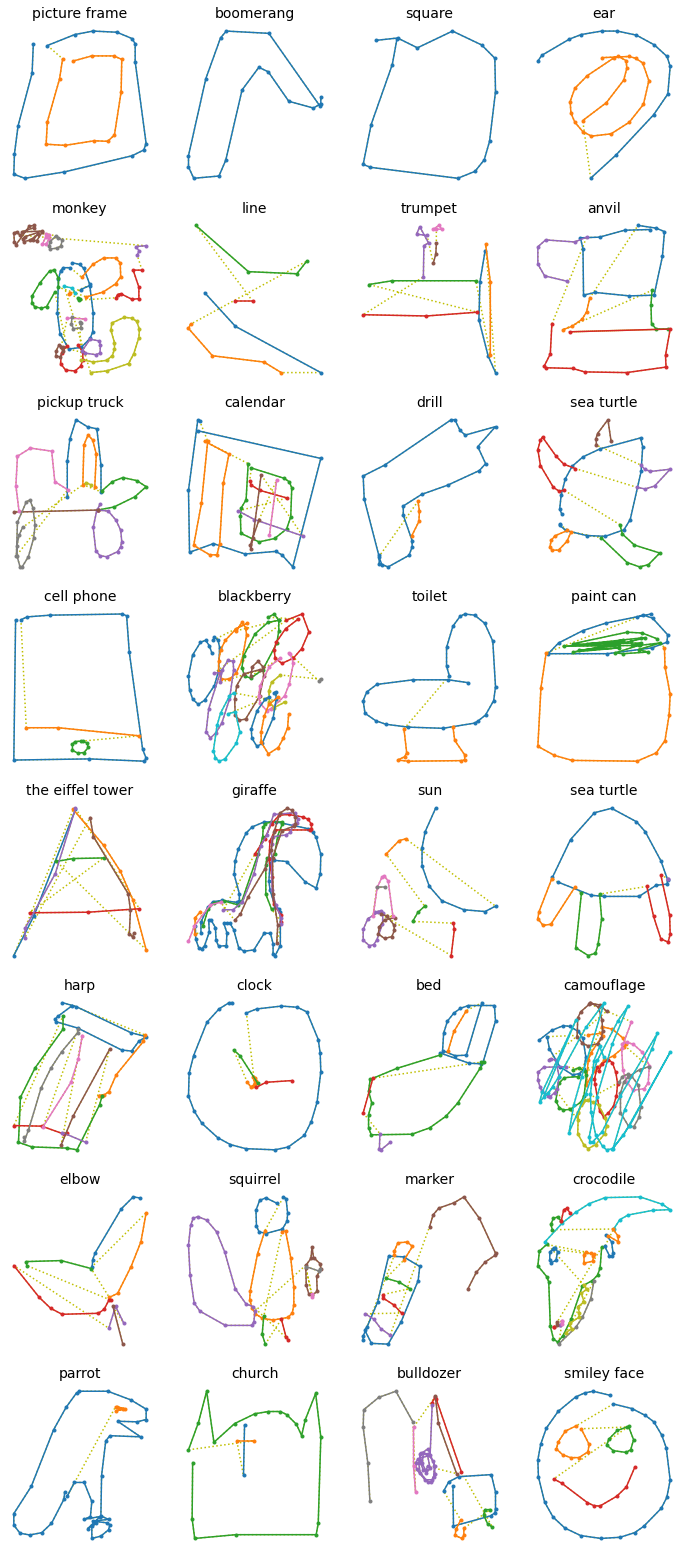

In [92]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

Most sketches are composed of less than 100 points:

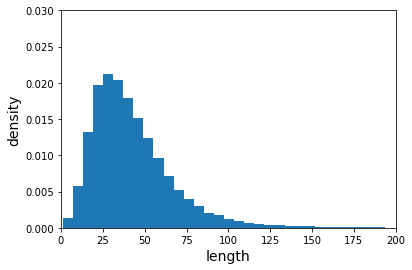

In [93]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [94]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [95]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 2048s 19ms/step - loss: 4.0817 - accuracy: 0.1705 - sparse_top_k_categorical_accuracy: 0.3747 - val_loss: 3.0628 - val_accuracy: 0.3127 - val_sparse_top_k_categorical_accuracy: 0.5969
Epoch 2/2
107813/107813 [==============================] - 3975s 37ms/step - loss: 2.7176 - accuracy: 0.3771 - sparse_top_k_categorical_accuracy: 0.6660 - val_loss: 2.4580 - val_accuracy: 0.4253 - val_sparse_top_k_categorical_accuracy: 0.7143


In [96]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [97]:
np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.60668993

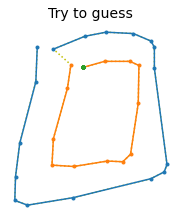

Top-5 predictions:
  1. popsicle 13.105%
  2. computer 7.943%
  3. television 7.032%
  4. laptop 6.640%
  5. cell phone 5.520%
Answer: picture frame


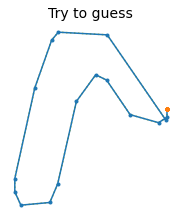

Top-5 predictions:
  1. garden hose 15.217%
  2. trumpet 10.083%
  3. rifle 8.203%
  4. spoon 5.367%
  5. moustache 4.533%
Answer: boomerang


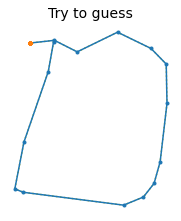

Top-5 predictions:
  1. wine bottle 24.326%
  2. hexagon 22.632%
  3. octagon 13.903%
  4. lipstick 2.759%
  5. blackberry 2.112%
Answer: square


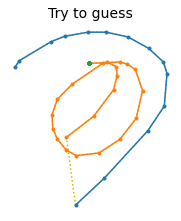

Top-5 predictions:
  1. ear 62.866%
  2. moon 17.284%
  3. boomerang 3.729%
  4. knee 2.912%
  5. squiggle 2.257%
Answer: ear


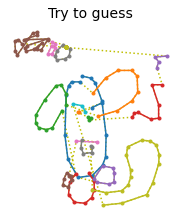

Top-5 predictions:
  1. monkey 34.293%
  2. mermaid 8.274%
  3. blueberry 7.341%
  4. camouflage 4.992%
  5. bear 4.961%
Answer: monkey


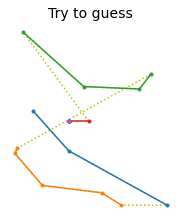

Top-5 predictions:
  1. fork 8.643%
  2. shovel 7.149%
  3. syringe 6.684%
  4. screwdriver 5.352%
  5. stitches 4.247%
Answer: line


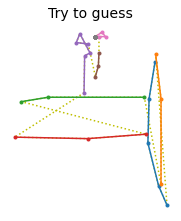

Top-5 predictions:
  1. snowflake 22.972%
  2. yoga 10.533%
  3. matches 6.915%
  4. candle 4.574%
  5. syringe 3.947%
Answer: trumpet


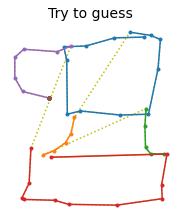

Top-5 predictions:
  1. shovel 15.070%
  2. floor lamp 10.788%
  3. screwdriver 10.516%
  4. lipstick 9.559%
  5. lantern 7.887%
Answer: anvil


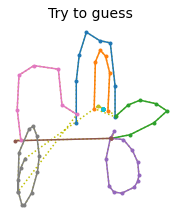

Top-5 predictions:
  1. blueberry 13.230%
  2. submarine 11.078%
  3. bicycle 9.777%
  4. motorbike 9.246%
  5. eyeglasses 8.239%
Answer: pickup truck


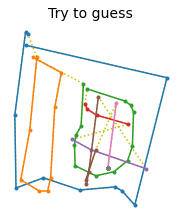

Top-5 predictions:
  1. stereo 21.389%
  2. radio 16.453%
  3. yoga 9.803%
  4. ant 6.983%
  5. power outlet 4.575%
Answer: calendar


In [98]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [99]:
model.save("my_sketchrnn", save_format="tf")

2022-02-18 16:47:16.114014: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: my_sketchrnn/assets


INFO:tensorflow:Assets written to: my_sketchrnn/assets


## 10. Bach Chorales
_Exercise: Download the [Bach chorales](https://homl.info/bach) dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note's index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out [Google's Coconet model](https://homl.info/coconet), which was used for a nice [Google doodle about Bach](https://www.google.com/doodles/celebrating-johann-sebastian-bach)._



In [100]:
tf.keras.utils.get_file(
    "jsb_chorales.tgz",
    "https://github.com/ageron/data/raw/main/jsb_chorales.tgz",
    cache_dir=".",
    extract=True)

131072/117793 [=================================] - 0s 0us/step


'./datasets/jsb_chorales.tgz'

In [101]:
jsb_chorales_dir = Path("datasets/jsb_chorales")
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [102]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [103]:
train_chorales[0]

[[74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [75, 70, 58, 55],
 [75, 70, 58, 55],
 [75, 70, 60, 55],
 [75, 70, 60, 55],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 70, 62, 55],
 [77, 70, 62, 55],
 [77, 69, 62, 55],
 [77, 69, 62, 55],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [77, 65, 62, 50],
 [77, 65, 62, 50],
 [77, 65, 60, 50],
 [77, 65, 60, 50],
 [74, 67, 58, 55],
 [74, 67, 58, 55],
 [74, 67, 58, 53],
 [74, 67, 58, 53],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 65, 57

Notes range from 36 (C1 = C on octave 1) to 81 (A5 = A on octave 5), plus 0 for silence:

In [104]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

Let's write a few functions to listen to these chorales (you don't need to understand the details here, and in fact there are certainly simpler ways to do this, for example using MIDI players, but I just wanted to have a bit of fun writing a synthesizer):

In [105]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = (note_duration * frequencies).round() / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

Now let's listen to a few chorales:

In [106]:
for index in range(3):
    play_chords(train_chorales[index])

Divine! :)

In order to be able to generate new chorales, we want to train a model that can predict the next chord given all the previous chords. If we naively try to predict the next chord in one shot, predicting all 4 notes at once, we run the risk of getting notes that don't go very well together (believe me, I tried). It's much better and simpler to predict one note at a time. So we will need to preprocess every chorale, turning each chord into an arpegio (i.e., a sequence of notes rather than notes played simultaneuously). So each chorale will be a long sequence of notes (rather than chords), and we can just train a model that can predict the next note given all the previous notes. We will use a sequence-to-sequence approach, where we feed a window to the neural net, and it tries to predict that same window shifted one time step into the future.

We will also shift the values so that they range from 0 to 46, where 0 represents silence, and values 1 to 46 represent notes 36 (C1) to 81 (A5).

And we will train the model on windows of 128 notes (i.e., 32 chords).

Since the dataset fits in memory, we could preprocess the chorales in RAM using any Python code we like, but I will demonstrate here how to do all the preprocessing using tf.data (there will be more details about creating windows using tf.data in the next chapter).

In [107]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values
    return tf.reshape(window, [-1]) # convert to arpegio

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

Now let's create the training set, the validation set and the test set:

In [108]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

Now let's create the model:

* We could feed the note values directly to the model, as floats, but this would probably not give good results. Indeed, the relationships between notes are not that simple: for example, if you replace a C3 with a C4, the melody will still sound fine, even though these notes are 12 semi-tones apart (i.e., one octave). Conversely, if you replace a C3 with a C\#3, it's very likely that the chord will sound horrible, despite these notes being just next to each other. So we will use an `Embedding` layer to convert each note to a small vector representation (see Chapter 16 for more details on embeddings). We will use 5-dimensional embeddings, so the output of this first layer will have a shape of `[batch_size, window_size, 5]`.
* We will then feed this data to a small WaveNet-like neural network, composed of a stack of 4 `Conv1D` layers with doubling dilation rates. We will intersperse these layers with `BatchNormalization` layers for faster better convergence.
* Then one `LSTM` layer to try to capture long-term patterns.
* And finally a `Dense` layer to produce the final note probabilities. It will predict one probability for each chorale in the batch, for each time step, and for each possible note (including silence). So the output shape will be `[batch_size, window_size, 47]`.

In [109]:
n_embedding_dims = 5

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    tf.keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 5)           235       
                                                                 
 conv1d_22 (Conv1D)          (None, None, 32)          352       
                                                                 
 batch_normalization_3 (Batc  (None, None, 32)         128       
 hNormalization)                                                 
                                                                 
 conv1d_23 (Conv1D)          (None, None, 48)          3120      
                                                                 
 batch_normalization_4 (Batc  (None, None, 48)         192       
 hNormalization)                                                 
                                                                 
 conv1d_24 (Conv1D)          (None, None, 64)        

Now we're ready to compile and train the model!

In [110]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
98/98 [==============================] - 25s 208ms/step - loss: 1.8695 - accuracy: 0.5301 - val_loss: 3.7034 - val_accuracy: 0.1226
Epoch 2/20
98/98 [==============================] - 22s 225ms/step - loss: 0.9034 - accuracy: 0.7638 - val_loss: 3.4941 - val_accuracy: 0.1050
Epoch 3/20
98/98 [==============================] - 23s 233ms/step - loss: 0.7523 - accuracy: 0.7916 - val_loss: 3.3243 - val_accuracy: 0.1938
Epoch 4/20
98/98 [==============================] - 23s 232ms/step - loss: 0.6756 - accuracy: 0.8074 - val_loss: 2.5097 - val_accuracy: 0.3022
Epoch 5/20
98/98 [==============================] - 22s 223ms/step - loss: 0.6188 - accuracy: 0.8193 - val_loss: 1.7532 - val_accuracy: 0.4628
Epoch 6/20
98/98 [==============================] - 23s 237ms/step - loss: 0.5788 - accuracy: 0.8280 - val_loss: 1.0323 - val_accuracy: 0.6826
Epoch 7/20
98/98 [==============================] - 25s 256ms/step - loss: 0.5396 - accuracy: 0.8374 - val_loss: 0.7257 - val_accuracy: 0.7910

I have not done much hyperparameter search, so feel free to iterate on this model now and try to optimize it. For example, you could try removing the `LSTM` layer and replacing it with `Conv1D` layers. You could also play with the number of layers, the learning rate, the optimizer, and so on.

Once you're satisfied with the performance of the model on the validation set, you can save it and evaluate it one last time on the test set:

In [111]:
model.save("my_bach_model", save_format="tf")
model.evaluate(test_set)

34/34 [==============================] - 3s 74ms/step - loss: 0.6631 - accuracy: 0.8164


[0.6630987524986267, 0.8163789510726929]

**Note:** There's no real need for a test set in this exercise, since we will perform the final evaluation by just listening to the music produced by the model. So if you want, you can add the test set to the train set, and train the model again, hopefully getting a slightly better model.

Now let's write a function that will generate a new chorale. We will give it a few seed chords, it will convert them to arpegios (the format expected by the model), and use the model to predict the next note, then the next, and so on. In the end, it will group the notes 4 by 4 to create chords again, and return the resulting chorale.

In [112]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note = model.predict(arpegio, verbose=0).argmax(axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

To test this function, we need some seed chords. Let's use the first 8 chords of one of the test chorales (it's actually just 2 different chords, each played 4 times):

In [113]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

Now we are ready to generate our first chorale! Let's ask the function to generate 56 more chords, for a total of 64 chords, i.e., 16 bars (assuming 4 chords per bar, i.e., a 4/4 signature):

In [114]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

This approach has one major flaw: it is often too conservative. Indeed, the model will not take any risk, it will always choose the note with the highest score, and since repeating the previous note generally sounds good enough, it's the least risky option, so the algorithm will tend to make notes last longer and longer. Pretty boring. Plus, if you run the model multiple times, it will always generate the same melody.

So let's spice things up a bit! Instead of always picking the note with the highest score, we will pick the next note randomly, according to the predicted probabilities. For example, if the model predicts a C3 with 75% probability, and a G3 with a 25% probability, then we will pick one of these two notes randomly, with these probabilities. We will also add a `temperature` parameter that will control how "hot" (i.e., daring) we want the system to feel. A high temperature will bring the predicted probabilities closer together, reducing the probability of the likely notes and increasing the probability of the unlikely ones.

In [115]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

Let's generate 3 chorales using this new function: one cold, one medium, and one hot (feel free to experiment with other seeds, lengths and temperatures). The code saves each chorale to a separate file. You can run these cells over an over again until you generate a masterpiece!

**Please share your most beautiful generated chorale with me on Twitter @aureliengeron, I would really appreciate it! :))**

In [116]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, temperature=0.8)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

In [117]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, temperature=1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

In [118]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, temperature=1.5)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

Lastly, you can try a fun social experiment: send your friends a few of your favorite generated chorales, plus the real chorale, and ask them to guess which one is the real one!

In [119]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")